In [1]:
import tensorflow as tf
import joblib
import numpy as np
from baselines.ppo2.policies import nature_cnn
from baselines.a2c.utils import conv, fc, conv_to_fc

import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
%matplotlib inline

In [2]:
tup = joblib.load('../scripts/experts/pong/irl_ablation_trained/caches/paths_50/full_cache_uint8.pkl')

In [3]:
def decoder_cnn(inpt, **conv_kwargs):
    activ = tf.nn.leaky_relu
    deconv = tf.nn.conv2d_transpose(input_layer, [3, 3, 1, 1], 
         [1, 26, 20, 1], [1, 2, 2, 1], padding='SAME', name=None)

In [4]:
class Encoder:
    def __init__(self, dOshape, dU, obs_dtype=tf.int32, dout=10, **conv_kwargs):
        self.obs_dtype = obs_dtype
        self.dOshape = dOshape
        self.dU = dU
        
        with tf.variable_scope('encoder') as _vs:
            self.obs_t = tf.placeholder(obs_dtype, list((None,) + self.dOshape), name='obs')
            self.act_t = tf.placeholder(tf.float32, [None, self.dU], name='act')
            
            h_obs, self.final_cnn_shape = dcgan_cnn(self.obs_t, **conv_kwargs)
            """
            h = tf.concat([h_obs, self.act_t], axis=1)
                
            self.output = fc(
                fc(h, 't1', nh=50, init_scale=np.sqrt(2)),
                'output', dout, init_scale=np.sqrt(2)
            )
            """
            self.output = h_obs
        
    def encode(self, obs, acts):
        return tf.get_default_session().run(self.output, feed_dict={
            self.obs_t: obs,
            #self.act_t: acts
        })

class Decoder:
    def __init__(self, encoding_shape, start_shape):
        self.encoding_shape = encoding_shape
        self.start_shape = start_shape
        with tf.variable_scope('decoder') as variable_scope:
            self.encoding = tf.placeholder(tf.float32, list((None,) + self.encoding_shape))
        
            enhance = fc(self.encoding, 'out_shape', nh=np.prod(start_shape))
            start_conv = tf.reshape(enhance, [-1, *start_shape])
            
            l1 = tf.layers.conv2d_transpose(start_conv, 64, 3, strides=1)
            l2 = tf.layers.conv2d_transpose(l1, 32, 4, strides=2)
            l3 = tf.layers.conv2d_transpose(l3, 4, 8, strides=4)
            y = tf.nn.sigmoid(c) * 255

In [161]:
def batch_norm(name, x):
    shape = (1, *x.shape[1:])
    with tf.variable_scope(name):
        mean = tf.get_variable('mean', shape, initializer=tf.constant_initializer(0.0))
        variance = tf.get_variable('variance', shape, initializer=tf.constant_initializer(1.0))
        offset = tf.get_variable('offset', shape, initializer=tf.constant_initializer(0.0))
        scale = tf.get_variable('scale', shape, initializer=tf.constant_initializer(1.0))
    return tf.nn.batch_normalization(
        x, mean, variance, offset, scale, 0.001, name
    )


def dcgan_cnn(images, dout, **conv_kwargs):
    activ = lambda name, inpt: tf.nn.leaky_relu(batch_norm(name, inpt), alpha=0.2)
    l1 = activ('l1', conv(images, 'c1', nf=32, rf=8, stride=4, init_scale=np.sqrt(2), **conv_kwargs))
    l2 = activ('l2', conv(l1, 'c2', nf=64, rf=4, stride=2, init_scale=np.sqrt(2), **conv_kwargs))
    l3 = activ('l3', conv(l2, 'c3', nf=64, rf=3, stride=1, init_scale=np.sqrt(2), **conv_kwargs))
    out = fc(conv_to_fc(l3),nh=dout, scope='final')
    return out, l3.shape

#def layer(inpt, nf, )


def decoder_cnn(embedding, start_conv_shape, dclasses):
    activ = lambda name, inpt: tf.nn.relu(inpt)#batch_norm(name, inpt))
    enhance = fc(embedding, 'out_shape', nh=np.prod(start_conv_shape))
    start_conv = tf.reshape(enhance, [-1, *start_conv_shape])
    tf.layers.conv2d_transpose(start_conv, 64, 3, strides=1)
    l1 = activ('l3inv', tf.layers.conv2d_transpose(start_conv, 64, 3, strides=1))
    l2 = activ('l2inv', tf.layers.conv2d_transpose(l1, 32, 4, strides=2))
    l3 = tf.layers.conv2d_transpose(l2, dclasses + 1, 8, strides=4)
    #bias = tf.get_variable('logit_bias', list(s.value for s in l3.shape[1:]), dtype=tf.float32)
    return l3


class VariationalAutoEncoder:
    @staticmethod
    def _check_obs(obs):
        assert (obs >= 0).all()
        assert (obs <= 255).all()
        
    @staticmethod
    def _process_obs_tensor(obs):
        # recenter and scale to tanh range, as per https://arxiv.org/pdf/1511.06434.pdf
        #return (tf.cast(obs, tf.float32) - tf.constant(127.0)) / tf.constant(128.0)
        return tf.cast(obs, tf.float32)
    
    @staticmethod
    def _unprocess_obs_tensor(obs):
        return (obs * tf.constant(128.0)) + tf.constant(127.0)
        
    def __init__(self, dOshape, dclasses, d_embedding, obs_dtype=tf.int32, dout=10, **conv_kwargs):
        self.obs_dtype = obs_dtype
        self.dOshape = dOshape
        #self.dU = dU
        self.dclasses = dclasses
        self.d_embedding = d_embedding
        
        with tf.variable_scope('encoder') as _es:
            self.obs_t = tf.placeholder(obs_dtype, list((None,) + self.dOshape), name='obs')
            #self.act_t = tf.placeholder(tf.float32, [None, self.dU], name='act')
            
            processed_obs_t = self._process_obs_tensor(self.obs_t)
            
            h_obs, final_conv_shape = dcgan_cnn(processed_obs_t, d_embedding, **conv_kwargs)
            
            self.encoding = h_obs
            self._final_conv_shape = tuple(s.value for s in final_conv_shape[1:])
            self.encoder_scope = _es
            
        self.encoding_shape = tuple(s.value for s in self.encoding.shape[1:])
        
        with tf.variable_scope('decoder') as _ds:
            self.noise = tf.placeholder(tf.float32, [None, self.d_embedding], name='noise')
            # This part of the observation model handles our class predictions
            self.logits = decoder_cnn(
                self.encoding + self.noise,
                self._final_conv_shape,
                self.dclasses
            )
            self.logp_class = tf.nn.log_softmax(self.logits)
            
            # this part of the observation model handles our softclass parameters
            means = tf.get_variable('mean', [self.dclasses], dtype=tf.float32, initializer=tf.random_uniform_initializer([self.dclasses], maxval=255))
            #means = tf.constant([0,  87, 147, 176, 236], dtype=tf.float32)
            sigsqs = tf.clip_by_value(
                tf.get_variable('sigsq', [self.dclasses], dtype=tf.float32, initializer=tf.random_normal_initializer([self.dclasses], stddev=0.1)),
                0,
                10
            )
            unk_value = tf.constant((1.0/255))
            self.dist = tf.distributions.Normal(loc=means, scale=sigsqs)
            
            self.decoder_scope = _ds
            
        with tf.variable_scope('optimization') as _os:
            #self.nobs_t = tf.placeholder(obs_dtype, list((None,) + self.dOshape), name='nobs')
            #processed_jobs_t = self.nobs_t
            
            frame = self.obs_t[:, :, :, -1:]
            
            self.logps = tf.concat([
                self.logp_class[:, :, :, :-1] + self.dist.log_prob(tf.cast(frame, tf.float32)),
                self.logp_class[:, :, :, -1:] + tf.log(unk_value)
            ], axis=3)
                            
            #logps = tf.log(ps)
            s = tf.reduce_logsumexp(self.logps, axis=3)
            print(s.shape)
            self.loss = -tf.reduce_mean(
                tf.reduce_sum(s, axis=[1,2])
            ) + .01 * tf.reduce_mean(
                tf.reduce_sum(self.encoding ** 2, axis=1)
            )
            
            self.lr = tf.placeholder(tf.float64, (), name='lr')
            #self.loss = tf.reduce_mean((self.prediction - processed_obs_t[:, :, :, -1:]) ** 2)
            self.step = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
            
            self.optimization_scope = _os
        
    def train(self, *, lr, obs, noise):
        self._check_obs(obs)
        loss, _ = tf.get_default_session().run(
            [self.loss, self.step], feed_dict={
                self.lr: lr,
                self.obs_t: obs,
                self.noise: noise
            }
        )
        return loss
    
    def encode(self, obs):
        self._check_obs(obs)
        return tf.get_default_session().run(self.encoding, feed_dict={
            self.obs_t: obs
        })
    
    def decode(self, encoding):
        noise = np.zeros(encoding.shape)
        return tf.get_default_session().run(
            [self.logp_class, self.dist.loc, self.dist.scale], feed_dict={
            self.encoding: encoding,
            self.noise: noise
        })
    
    def _check(self, tensor, obs):
        self._check_obs(obs)
        return tf.get_default_session().run(tensor, feed_dict={
            self.obs_t: obs
        })

In [162]:
obs = tup[0][:100]
#obs = np.zeros(10, 84, 84, 4)


(?, 84, 84)
1 45388.91
[231.03493  149.69315  156.26021  111.84988  192.00955   29.902788
  49.33564   54.50347   27.498583  34.19728   89.50044  240.72389
 135.82295  121.13196  203.3552   253.86345  156.08922  153.88724
  61.942696 189.57481 ]
101 23948.275
201 23506.592
301 23392.646
401 23351.535
501 23329.77
601 23314.965
701 23298.193
801 23279.129
901 23844.688
1001 23406.23
[231.24437  149.4133   156.4779   111.84831  191.97057   29.96582
  49.408035  54.50495   27.552244  34.2581    89.25459  240.4577
 135.97867  121.04563  203.37358  253.84764  155.90288  153.83183
  61.94711  189.29953 ]
1101 23339.37
1201 23312.658
1301 23295.918
1401 23281.31
1501 23269.566
1601 23260.125
1701 23251.467
1801 23243.07
1901 23235.088
2001 23226.807
[231.45534  149.16743  156.73976  111.84831  191.97057   29.96586
  49.58638   54.491035  27.552244  34.2581    89.01871  240.20718
 136.13324  120.86376  203.35846  253.84764  155.80286  153.65854
  61.945522 189.0484  ]
2101 23218.684
2201 23210

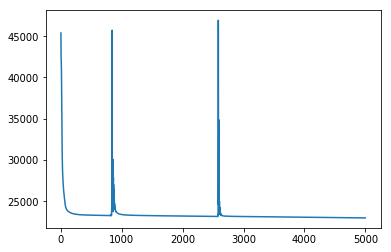

In [163]:
def lookup_obs(logits, dclasses):
    assert logits.shape[-1].value == dclasses
    lookup = tf.Tensor([np.random.randint(255) * 1.0 for _ in range(dclasses)], dtype=tf.float32)
    
    
with tf.Graph().as_default() as graph:
    with tf.Session().as_default() as sess:
        d_embedding = 30
        vae = VariationalAutoEncoder((84, 84, 4), 20, d_embedding)
        
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())
        
        data = []
        for i in range(5000):
            if i % 100 == 1:
                print(i, data[-1])
            if i % 1000 == 1:
                roundtrip = vae.decode(vae.encode(obs))
                print(roundtrip[1])
            data.append(vae.train(lr=2.5e-4, obs=obs, noise=np.zeros((obs.shape[0], d_embedding))))
            
        plt.plot(range(len(data)), data)
        plt.show()
        
        roundtrip = vae.decode(vae.encode(tup[0][:500]))
        
        #import pdb; pdb.set_trace()

In [164]:
preds, means, stds = roundtrip

In [165]:
means = np.hstack([means, np.array(255/2)])

In [166]:
img = (np.exp(preds) * means).sum(axis=3)
print(img.shape)

(500, 84, 84)


In [167]:
stds

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10.], dtype=float32)

In [168]:
rounded_means = [int(m) for m in means] + [0]

In [169]:
elements, counts = np.unique(tup[0][:100], return_counts=True)
elements[counts > np.sum(counts) * 1/100]

array([  0,  87, 147, 176, 236], dtype=uint8)

In [170]:
rounded_means

[232,
 148,
 157,
 111,
 191,
 29,
 50,
 54,
 27,
 34,
 88,
 239,
 135,
 120,
 202,
 253,
 155,
 153,
 61,
 188,
 127,
 0]

In [171]:
#img = np.take(rounded_means, preds.argmax(axis=3))

(array([5.100000e+01, 8.000000e+00, 3.400000e+01, 4.550000e+02,
        1.770000e+02, 6.700000e+01, 5.200000e+01, 3.000000e+01,
        2.800000e+01, 2.000000e+01, 4.000000e+01, 1.140000e+02,
        3.000000e+01, 2.600000e+01, 2.400000e+01, 1.600000e+01,
        9.000000e+00, 1.400000e+01, 1.300000e+01, 1.500000e+01,
        7.500000e+01, 1.560000e+02, 5.700000e+01, 5.900000e+01,
        5.800000e+01, 3.300000e+01, 3.500000e+01, 2.800000e+01,
        4.300000e+01, 3.600000e+01, 3.200000e+01, 6.900000e+01,
        1.250000e+02, 3.030000e+02, 2.200000e+02, 1.313000e+03,
        4.030000e+03, 9.274000e+03, 1.753500e+04, 3.367500e+04,
        1.055450e+05, 3.315121e+06, 5.395000e+03, 6.308000e+03,
        3.968000e+03, 9.371000e+03, 1.612000e+03, 7.140000e+02,
        6.710000e+02, 5.410000e+02, 4.980000e+02, 4.420000e+02,
        4.370000e+02, 4.030000e+02, 3.640000e+02, 4.690000e+02,
        4.770000e+02, 3.550000e+02, 2.890000e+02, 3.600000e+02,
        4.640000e+02, 6.910000e+02, 5.87

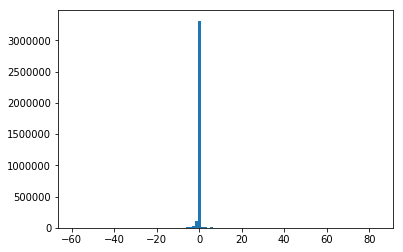

In [172]:
mean_img = img.mean(axis=0)
np.mean((img - mean_img) ** 2)
plt.hist((img - mean_img).reshape(img.shape[0] * 84 * 84), bins=100)

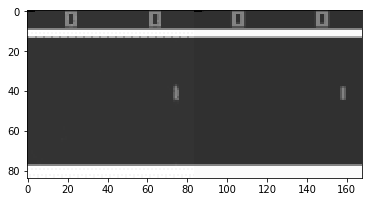

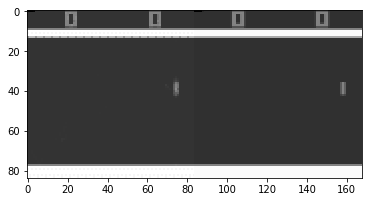

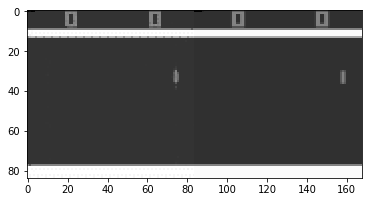

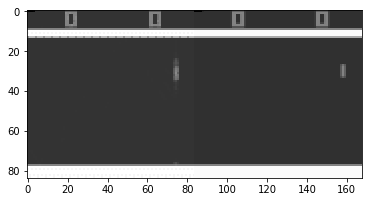

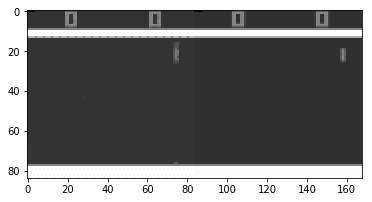

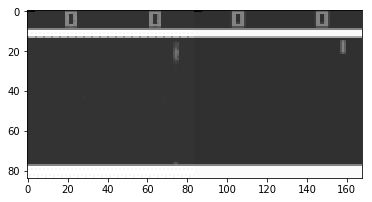

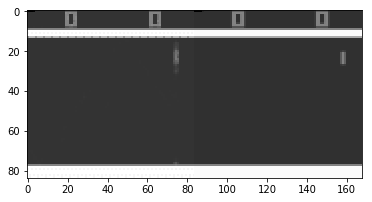

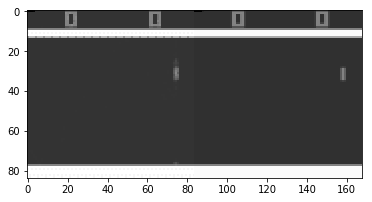

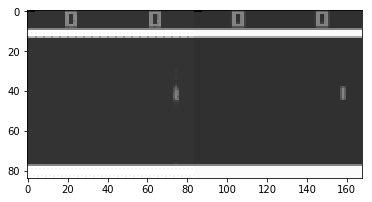

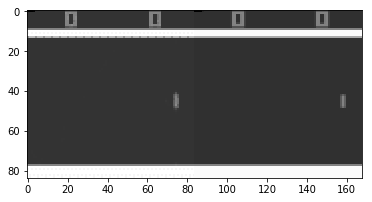

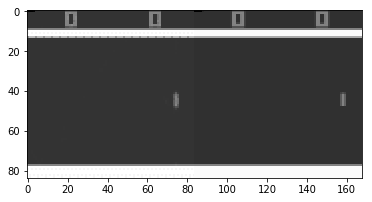

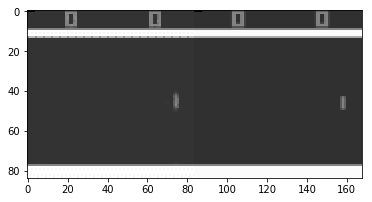

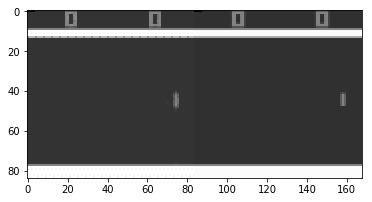

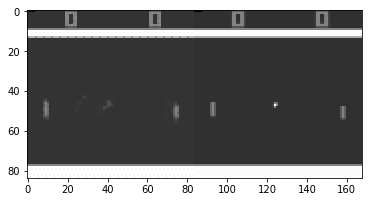

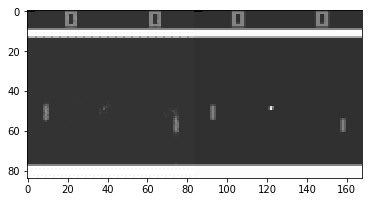

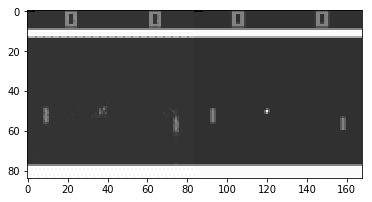

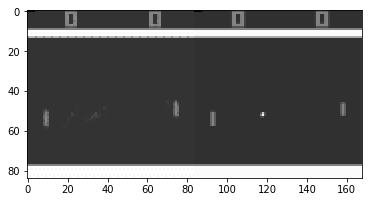

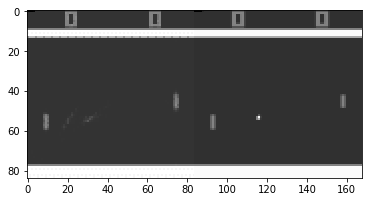

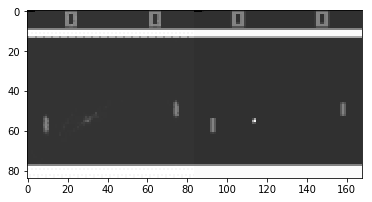

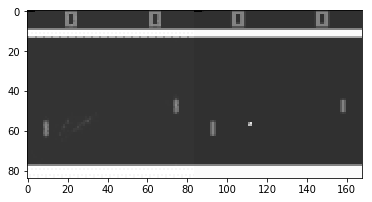

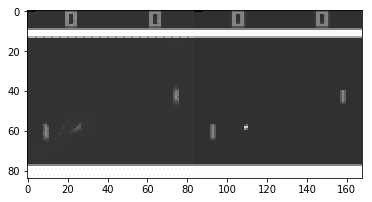

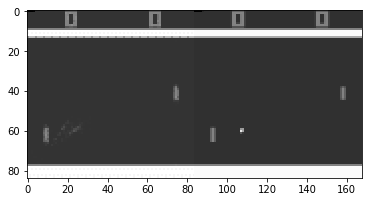

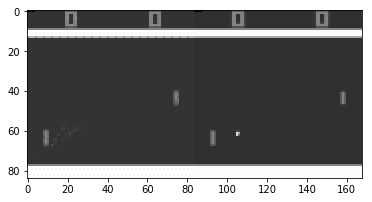

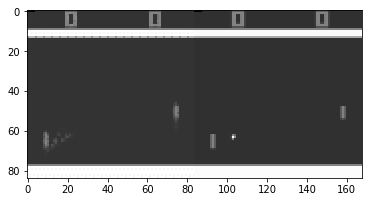

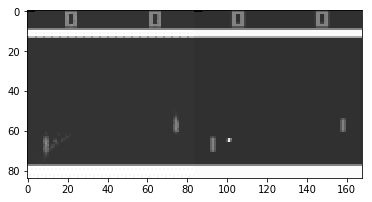

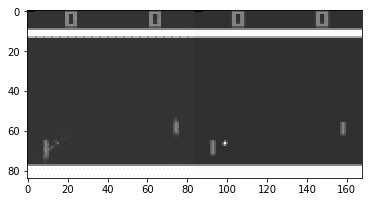

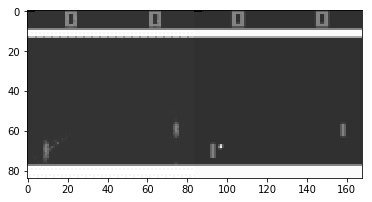

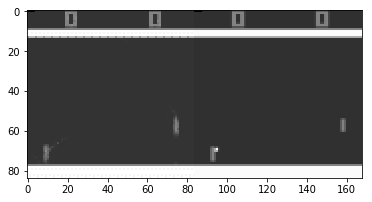

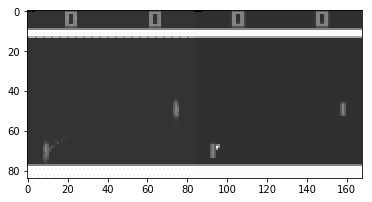

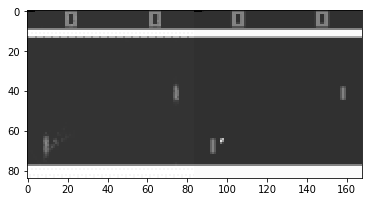

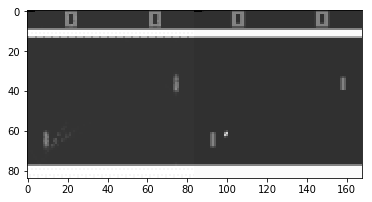

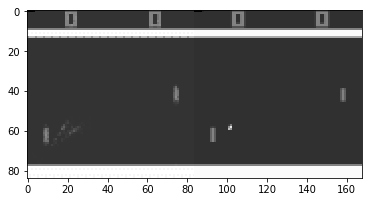

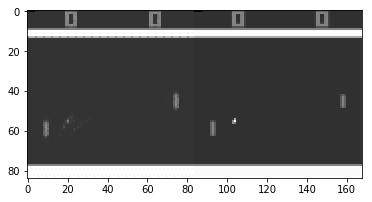

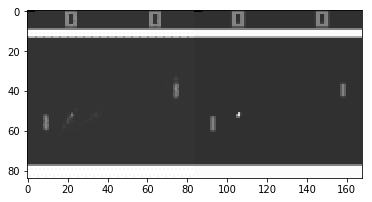

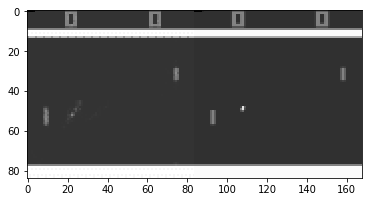

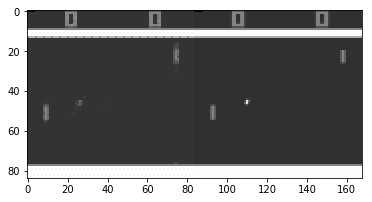

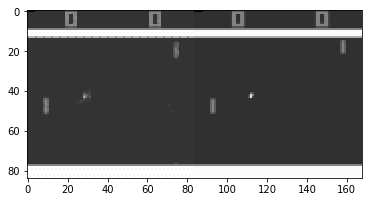

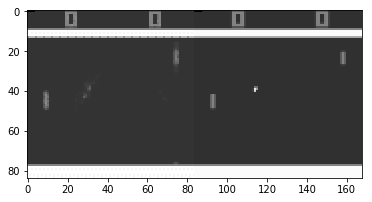

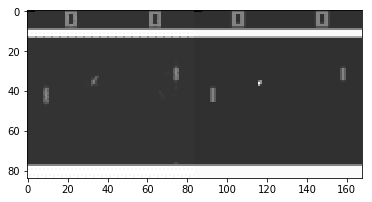

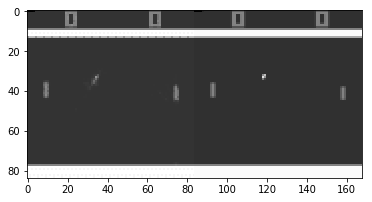

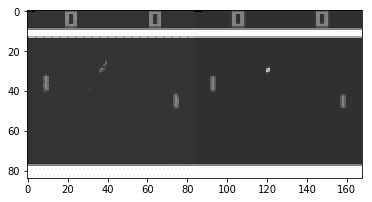

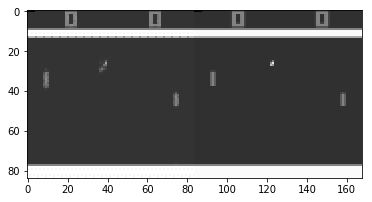

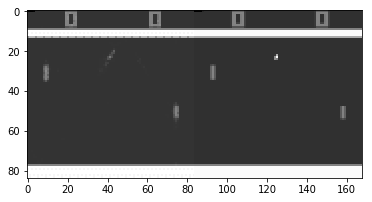

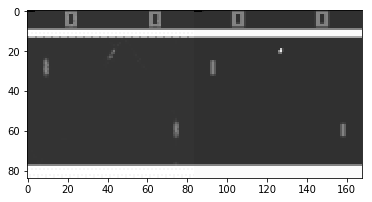

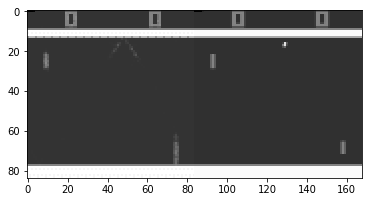

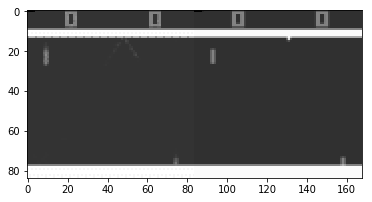

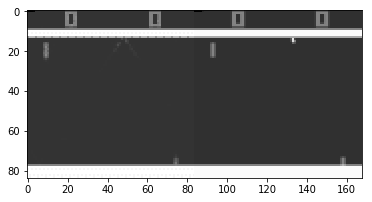

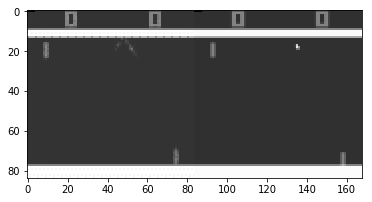

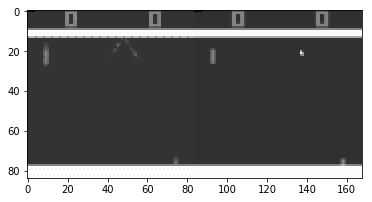

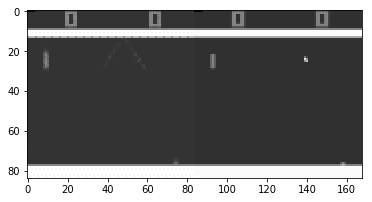

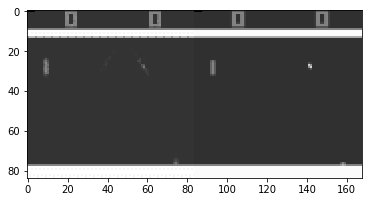

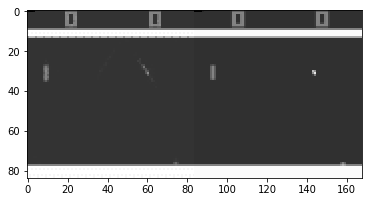

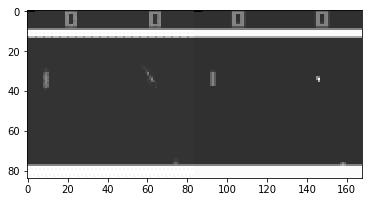

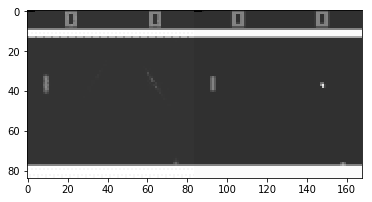

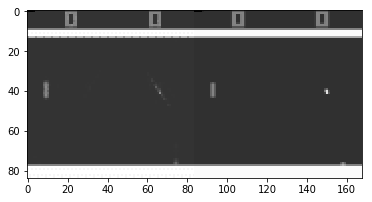

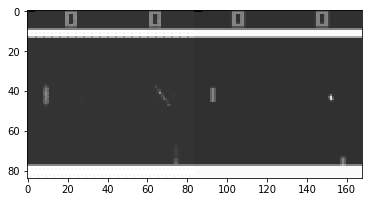

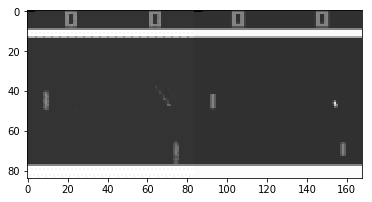

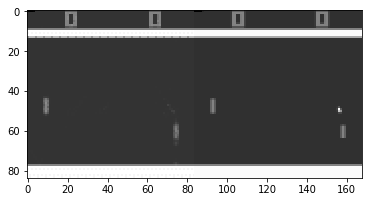

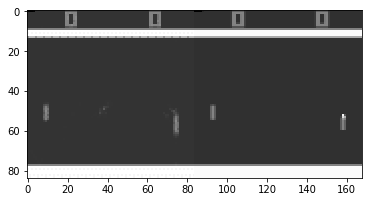

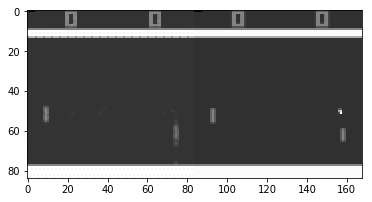

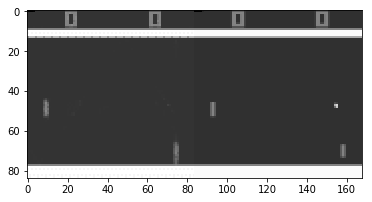

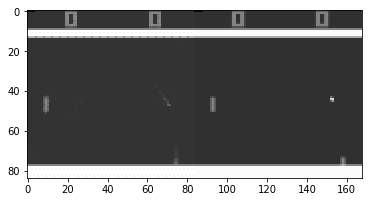

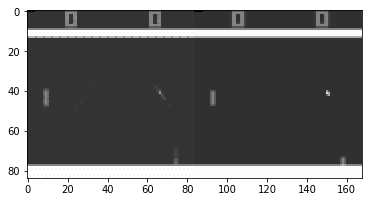

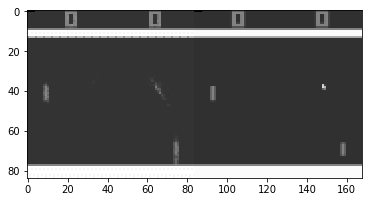

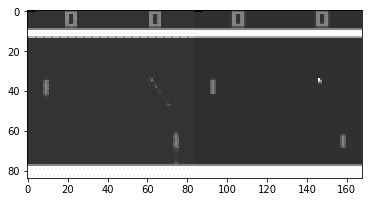

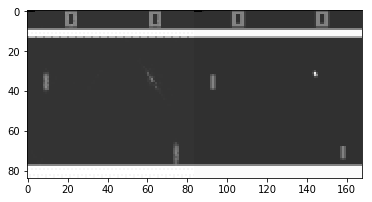

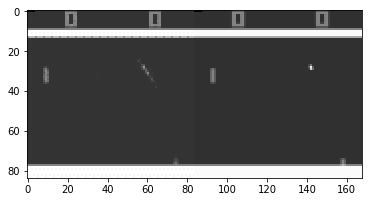

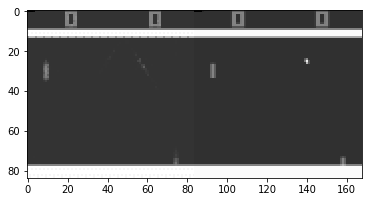

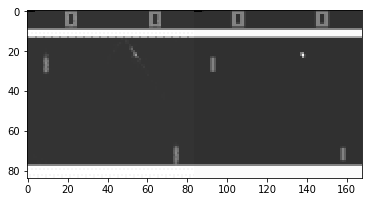

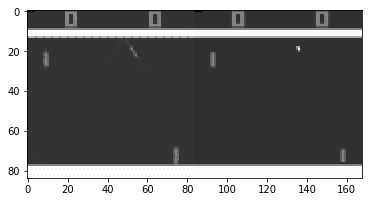

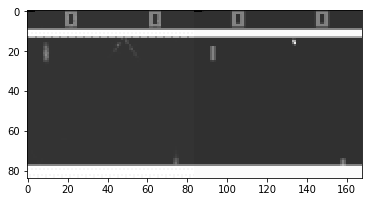

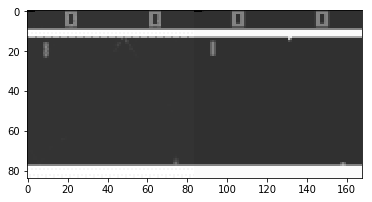

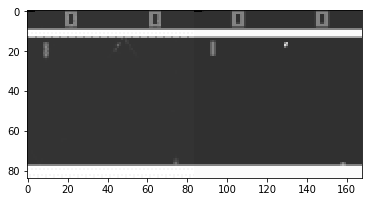

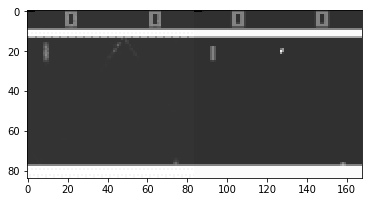

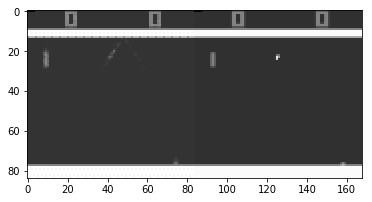

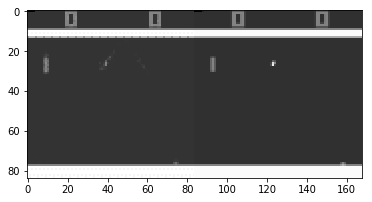

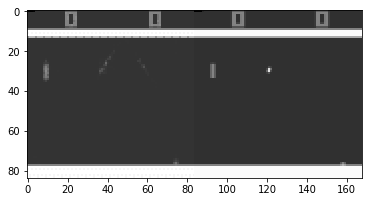

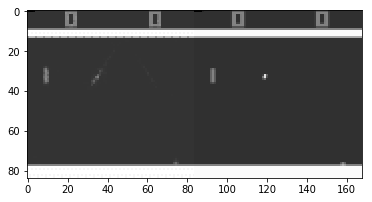

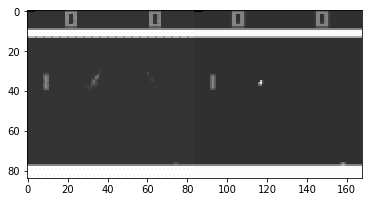

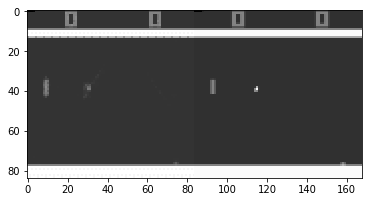

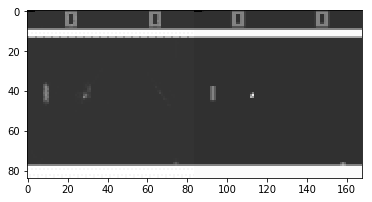

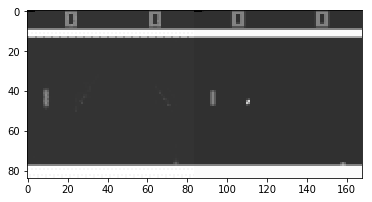

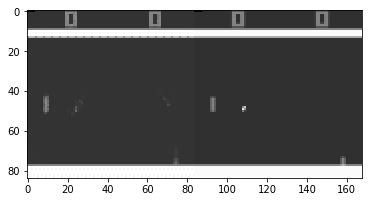

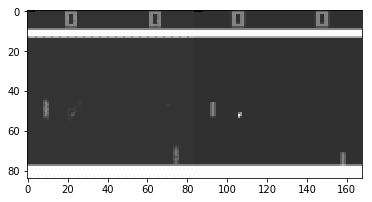

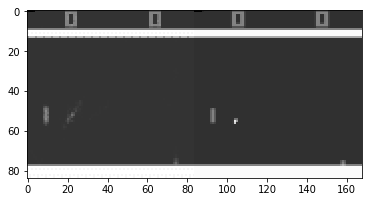

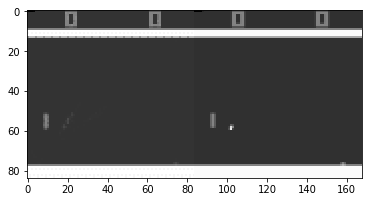

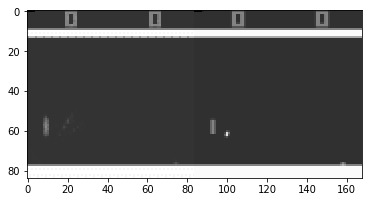

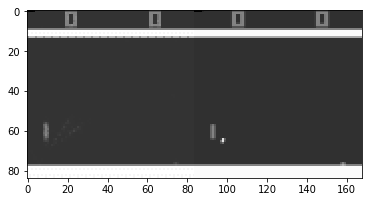

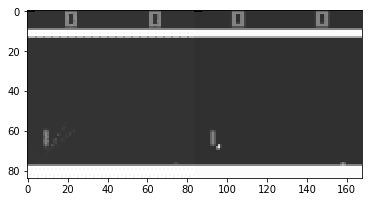

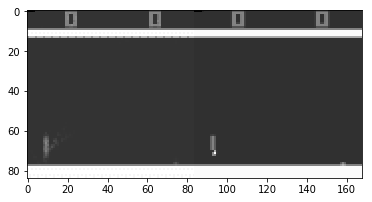

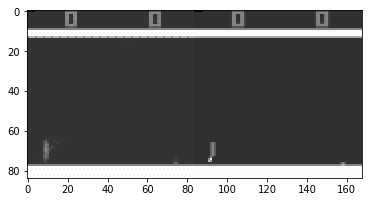

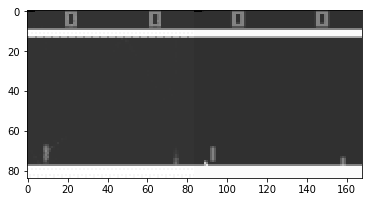

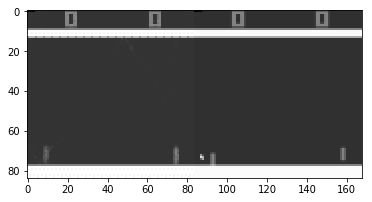

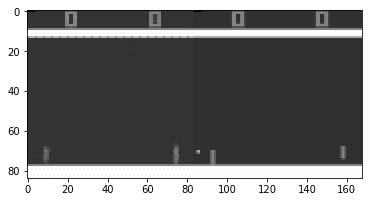

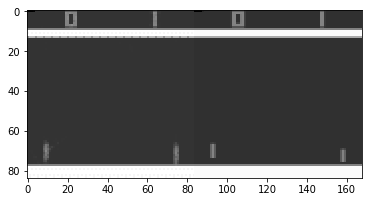

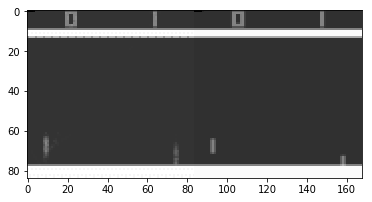

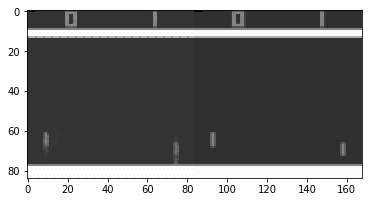

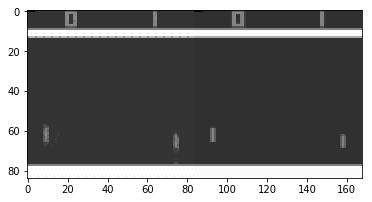

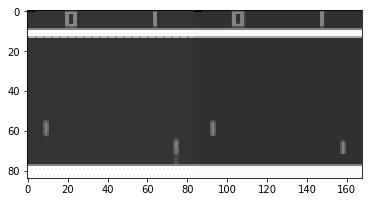

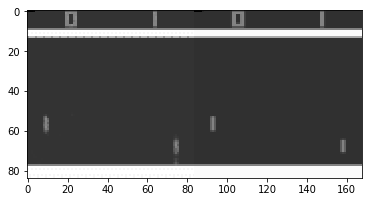

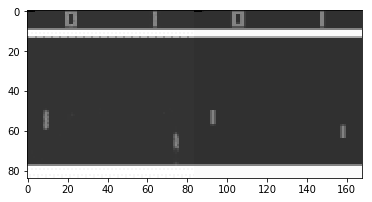

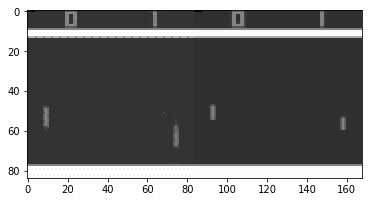

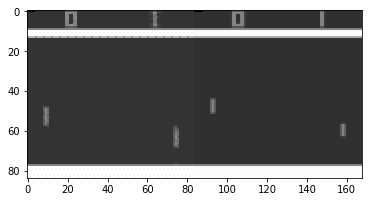

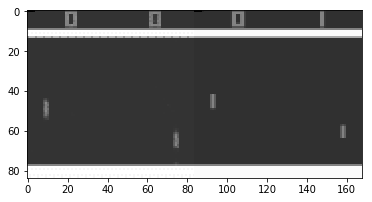

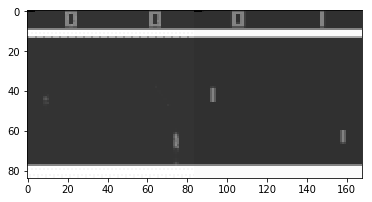

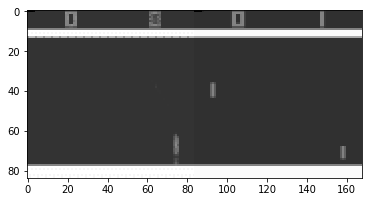

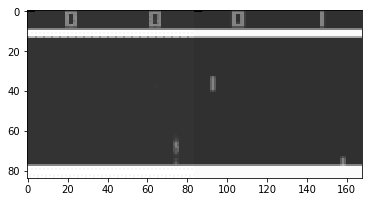

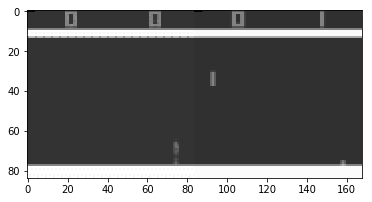

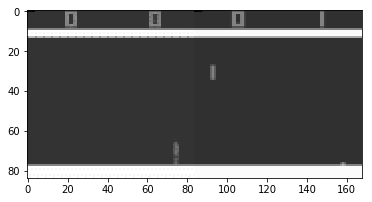

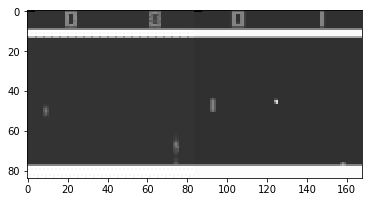

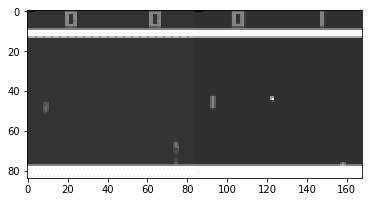

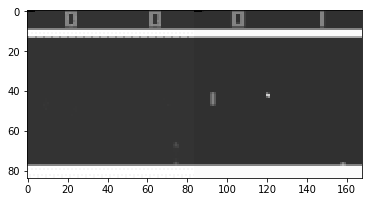

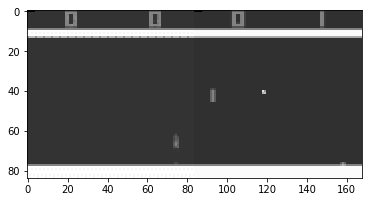

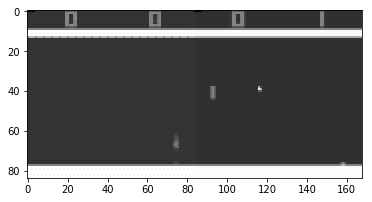

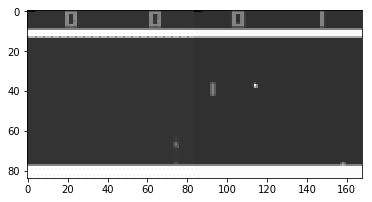

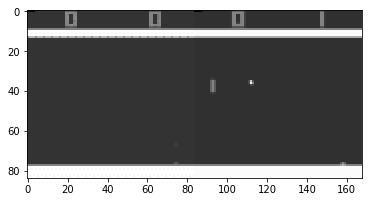

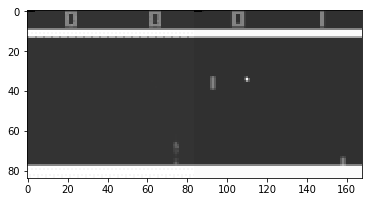

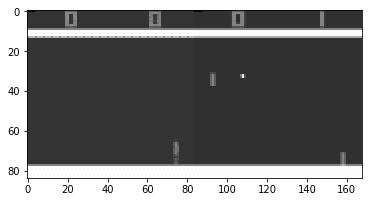

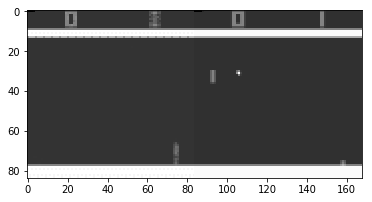

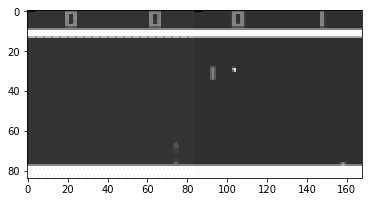

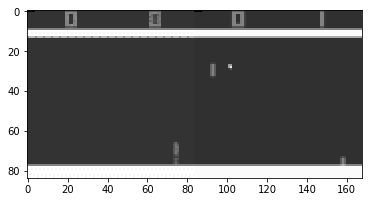

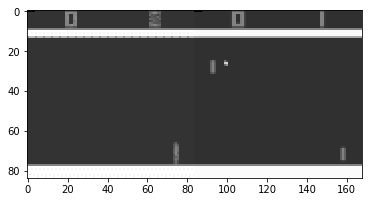

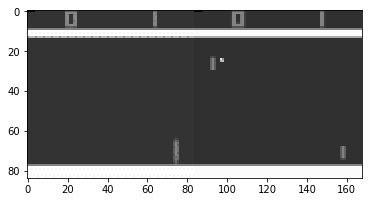

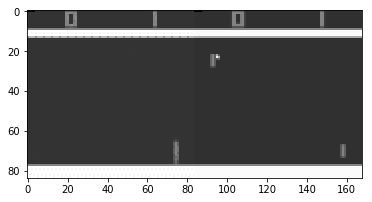

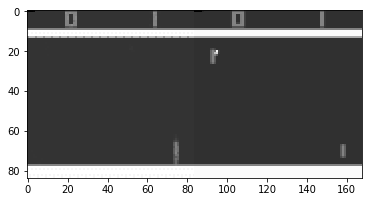

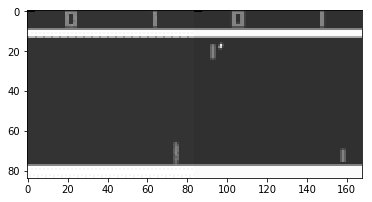

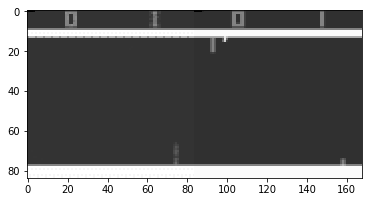

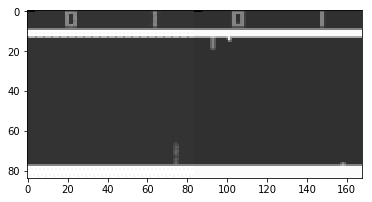

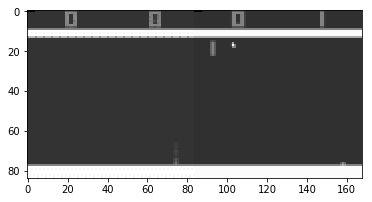

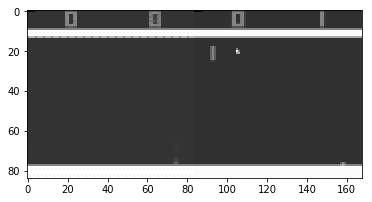

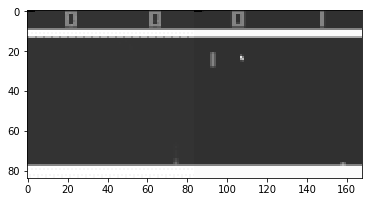

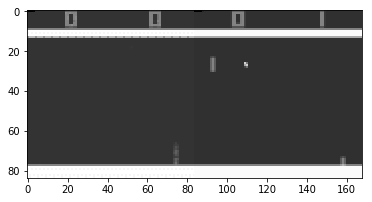

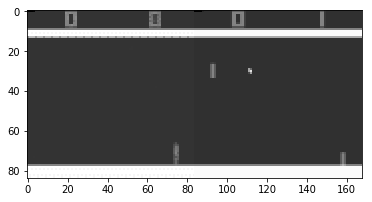

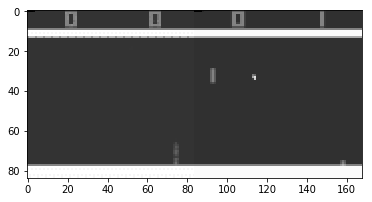

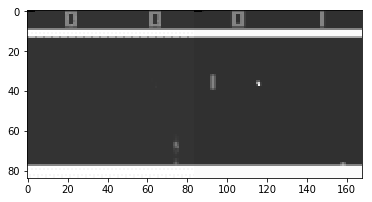

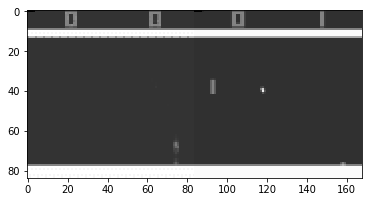

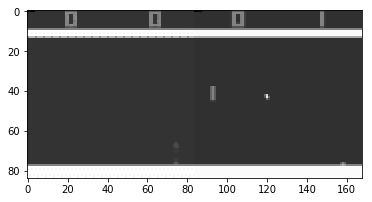

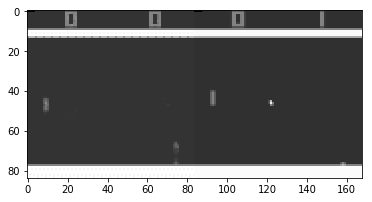

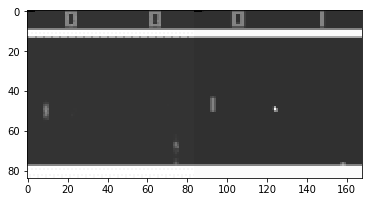

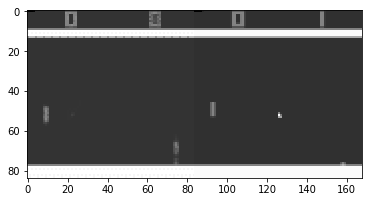

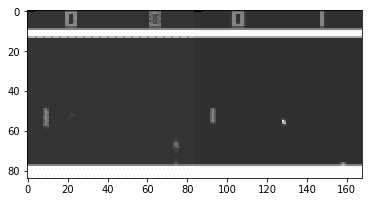

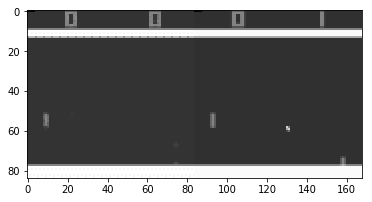

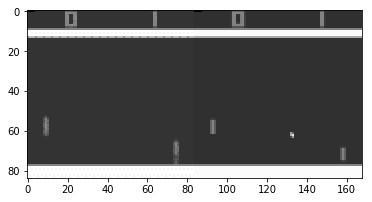

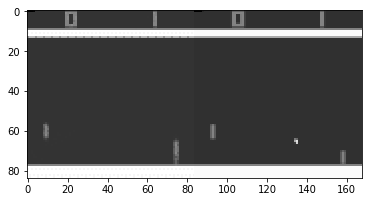

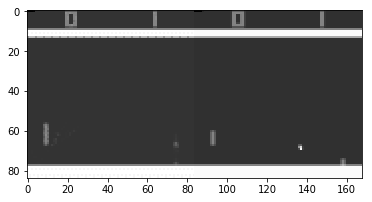

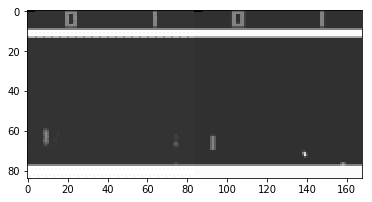

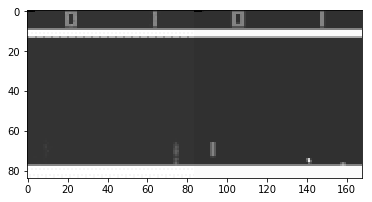

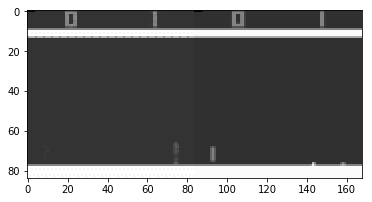

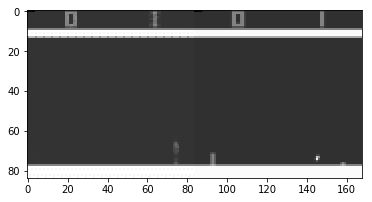

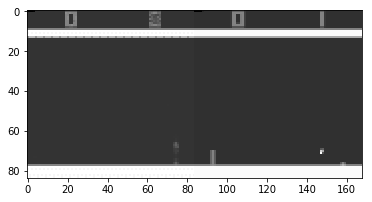

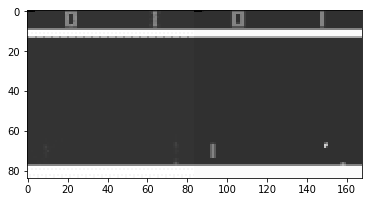

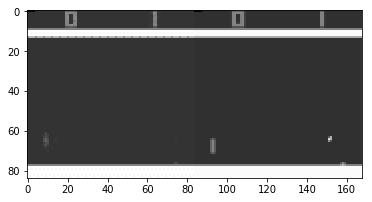

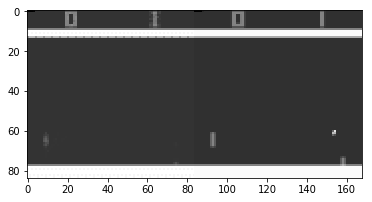

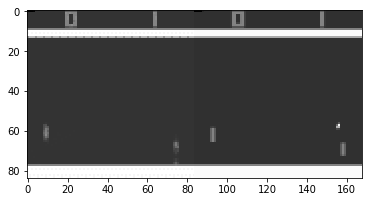

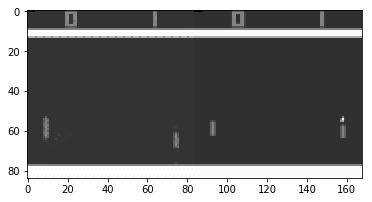

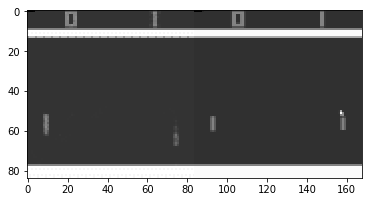

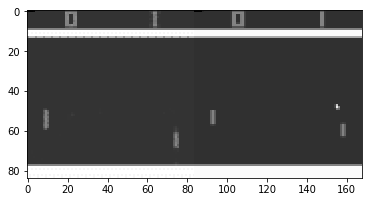

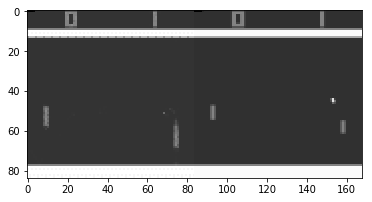

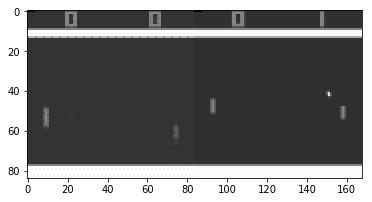

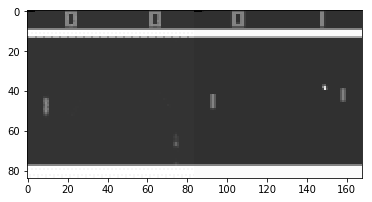

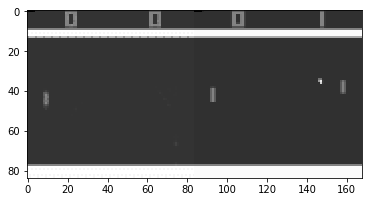

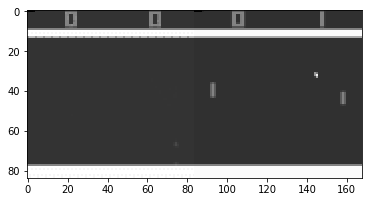

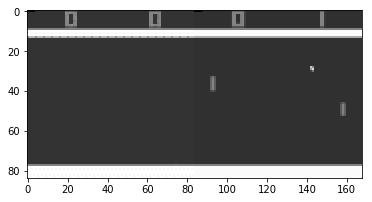

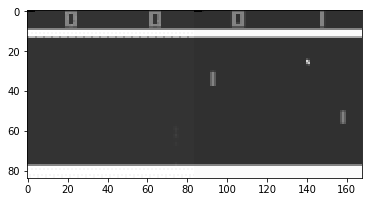

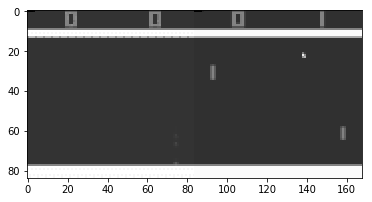

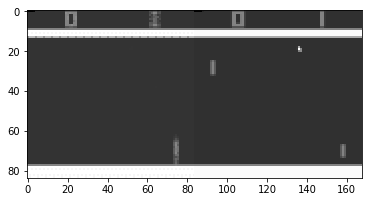

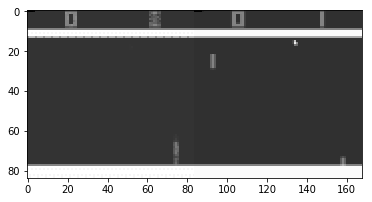

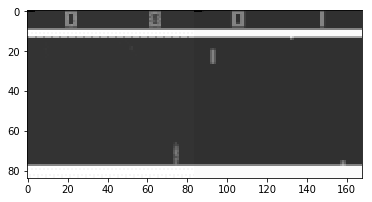

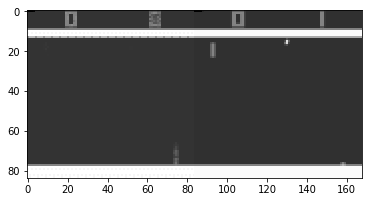

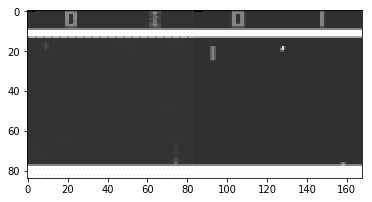

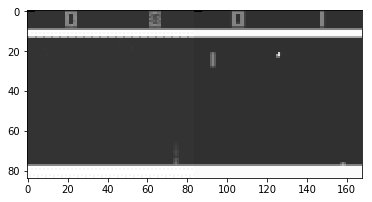

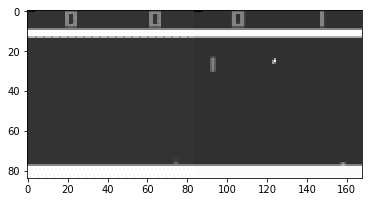

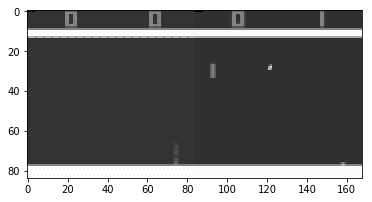

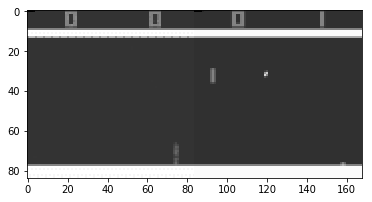

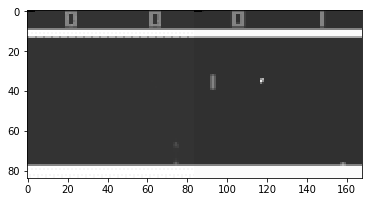

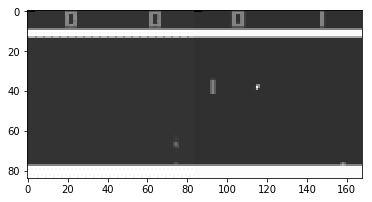

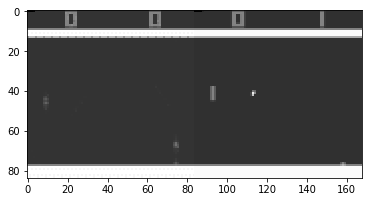

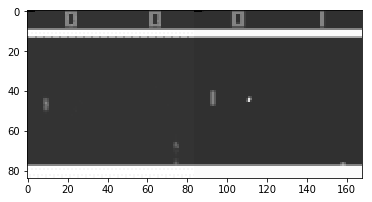

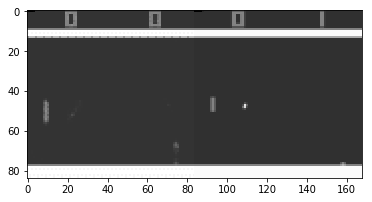

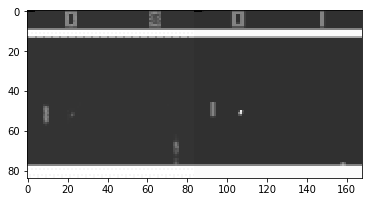

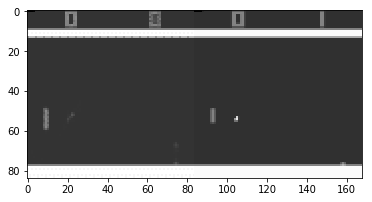

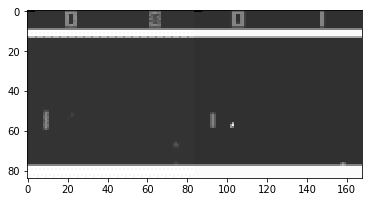

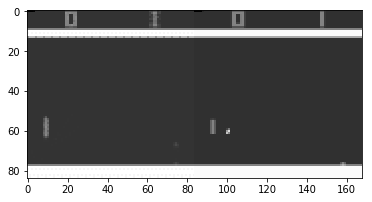

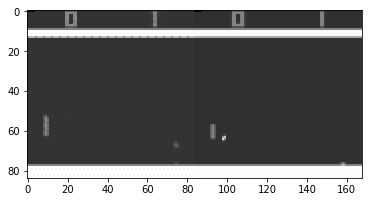

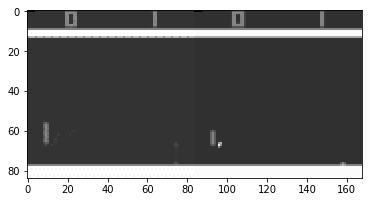

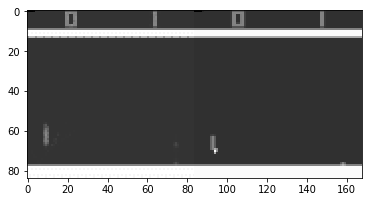

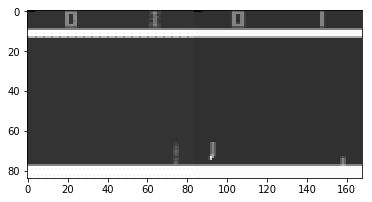

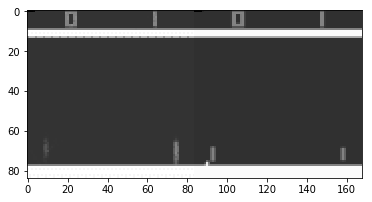

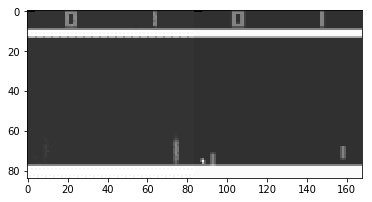

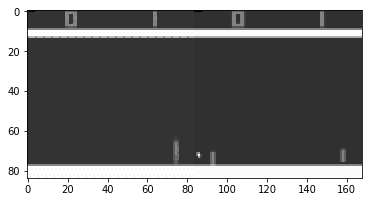

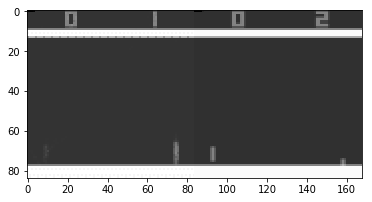

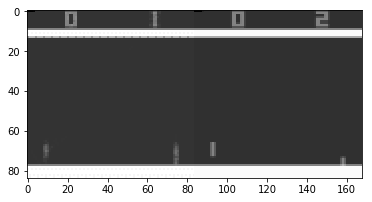

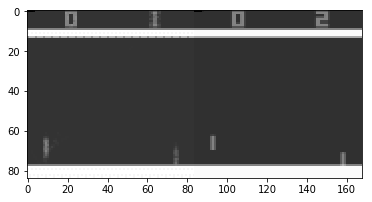

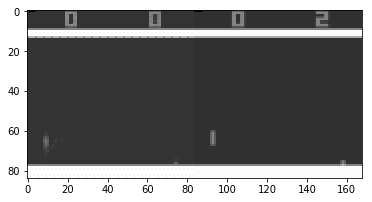

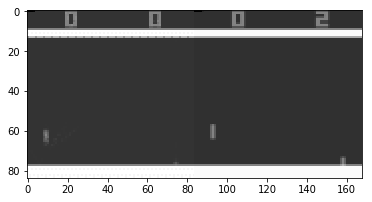

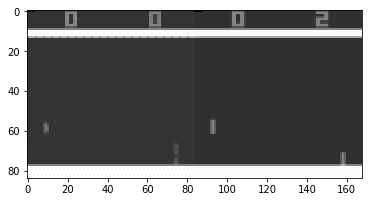

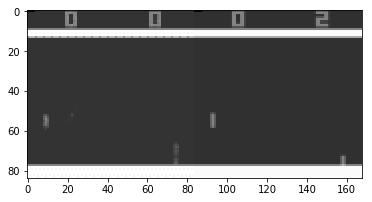

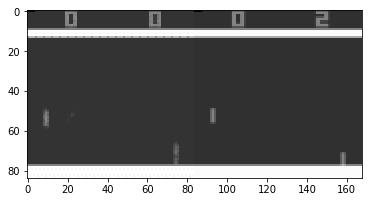

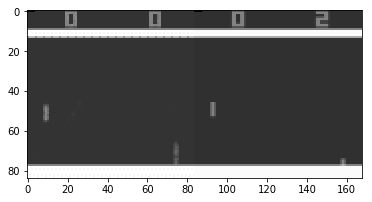

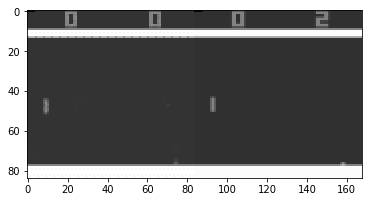

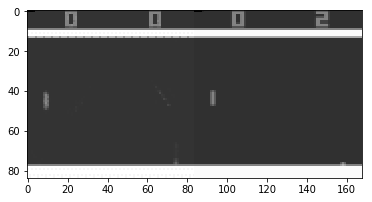

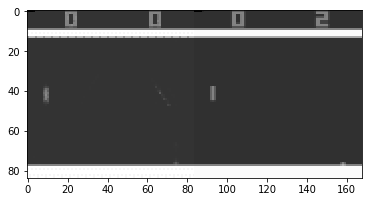

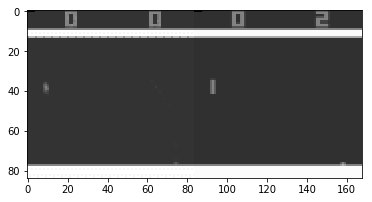

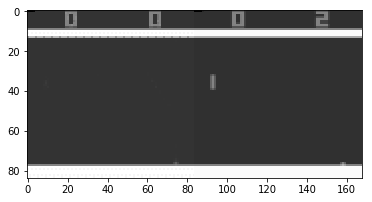

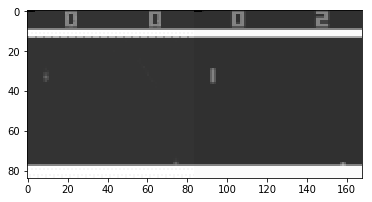

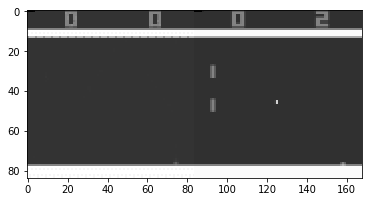

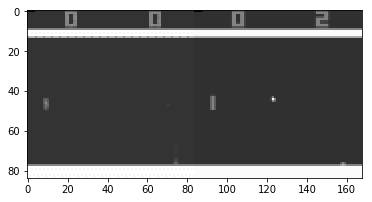

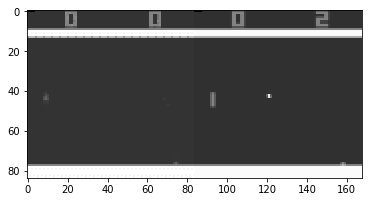

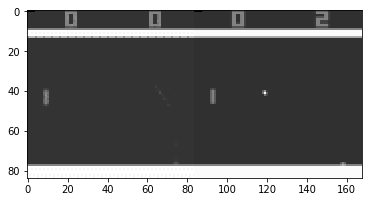

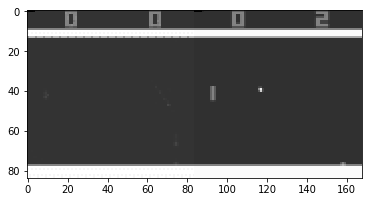

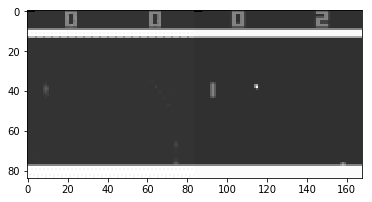

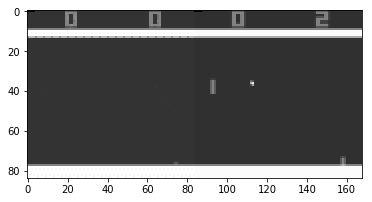

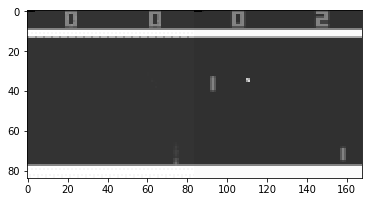

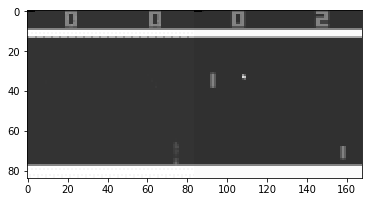

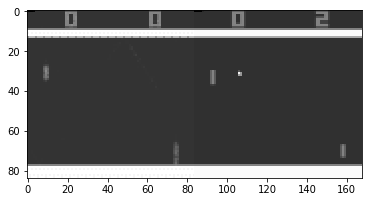

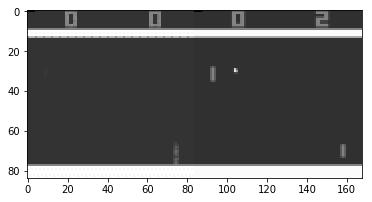

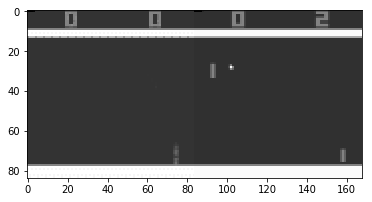

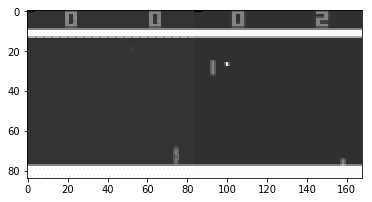

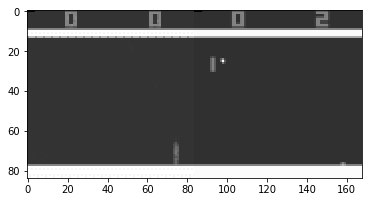

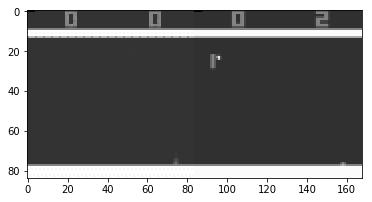

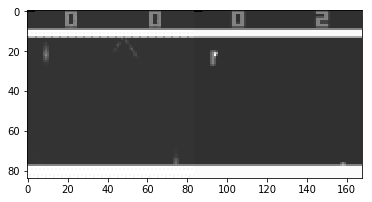

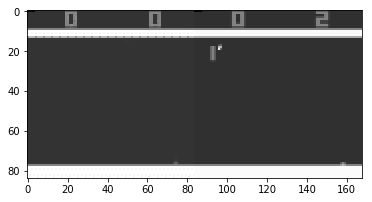

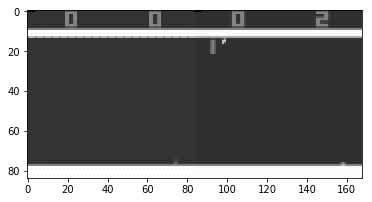

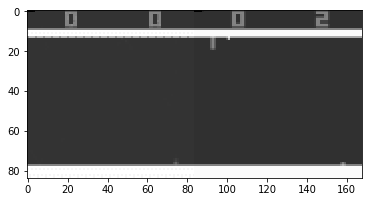

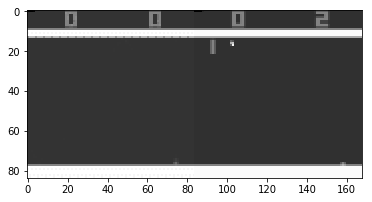

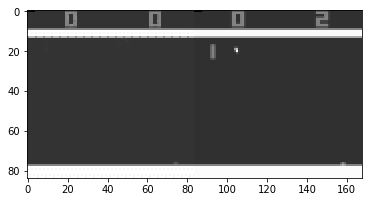

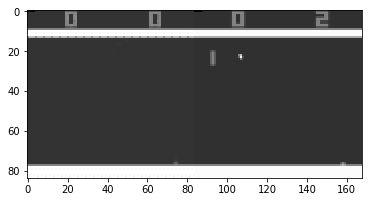

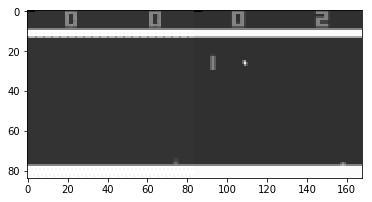

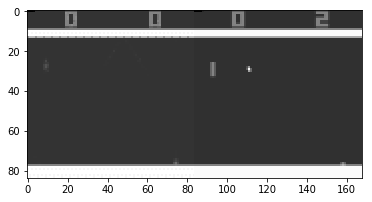

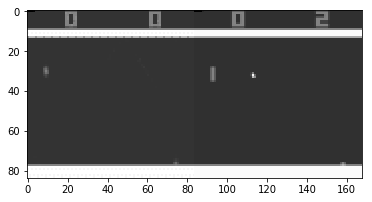

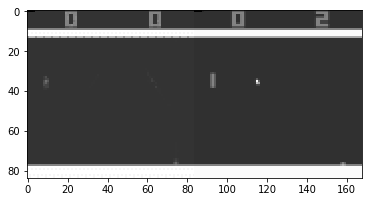

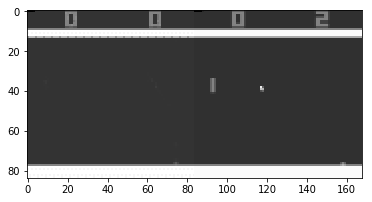

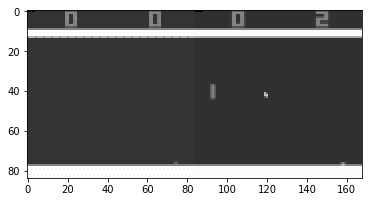

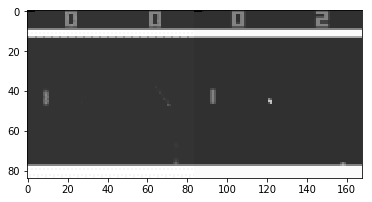

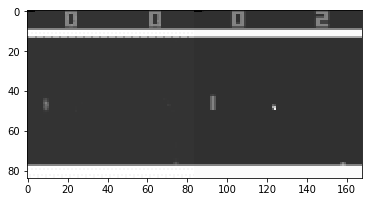

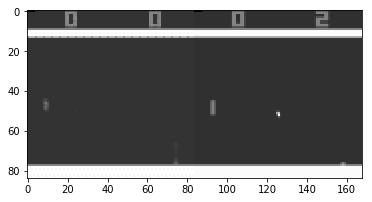

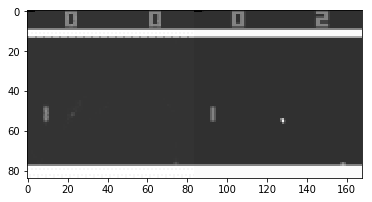

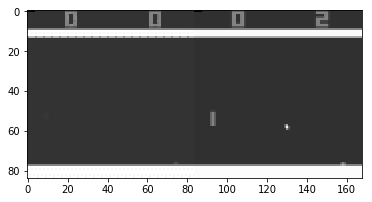

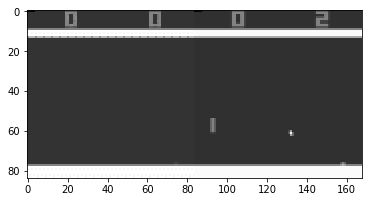

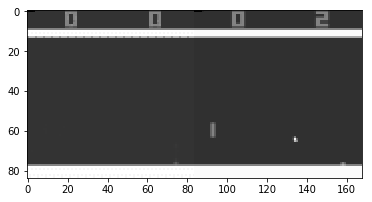

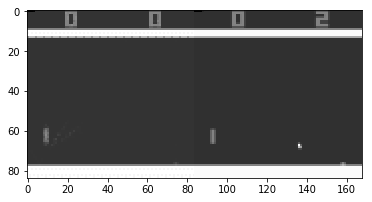

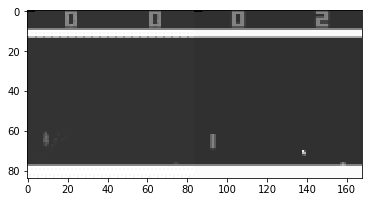

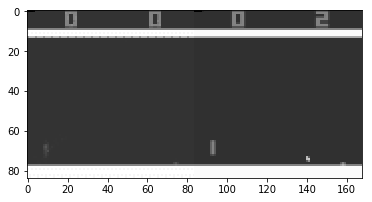

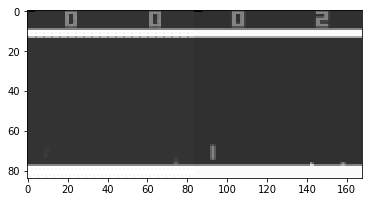

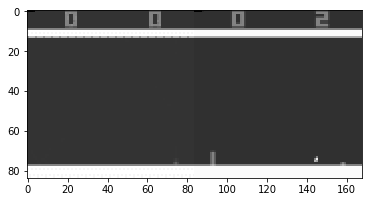

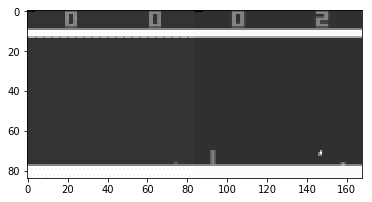

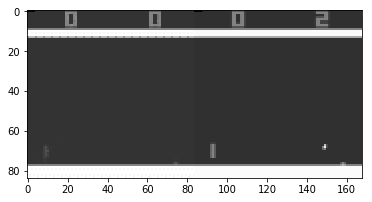

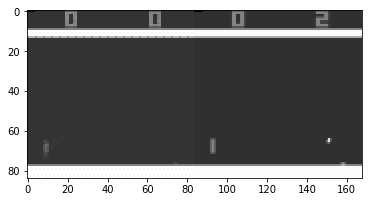

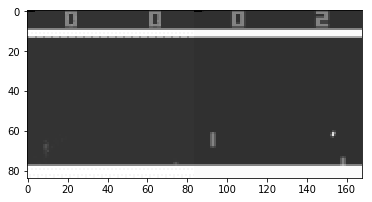

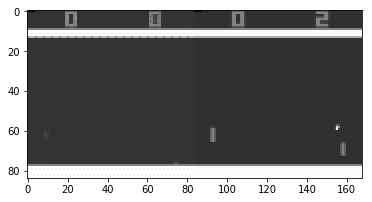

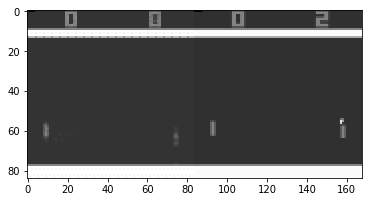

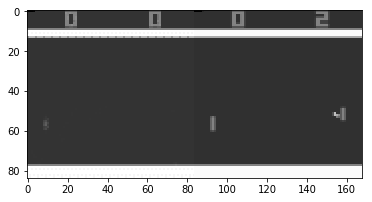

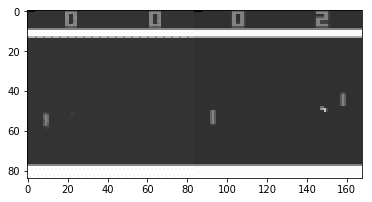

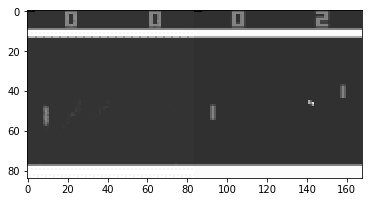

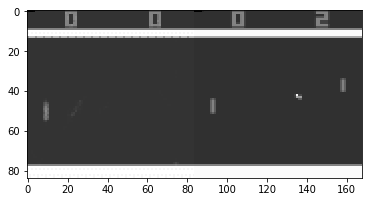

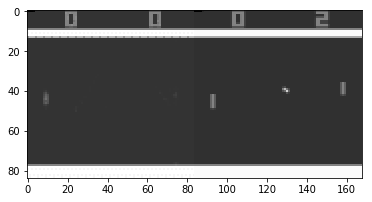

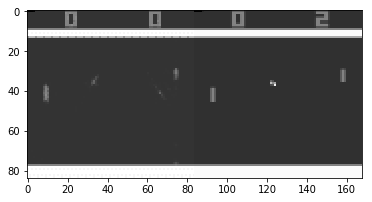

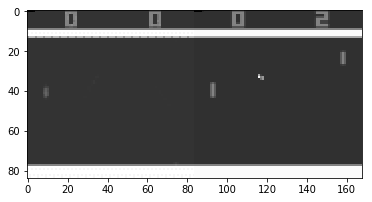

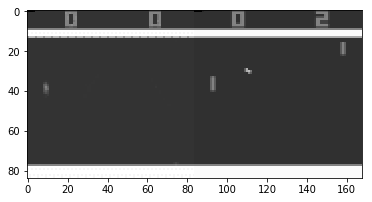

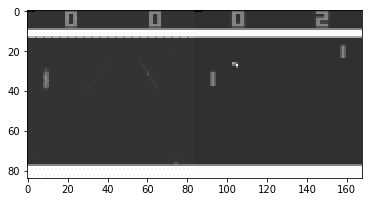

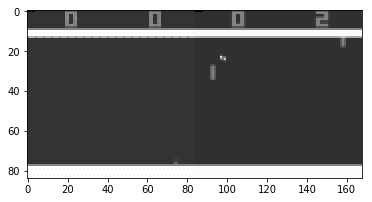

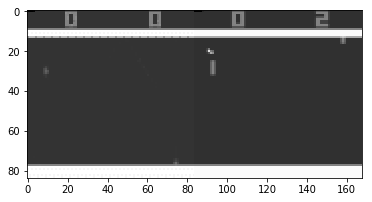

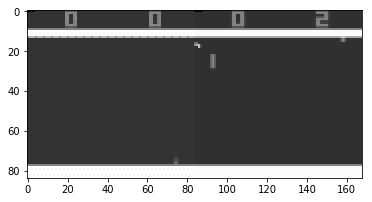

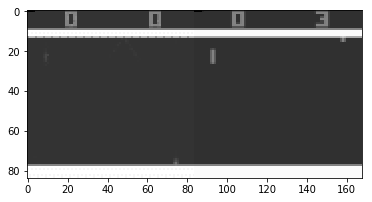

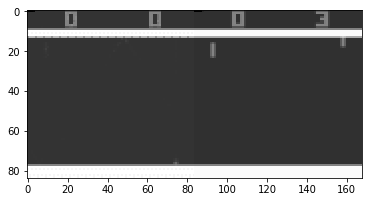

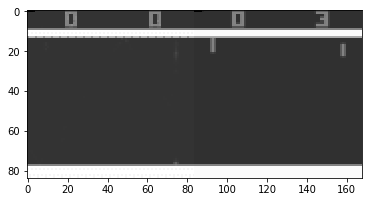

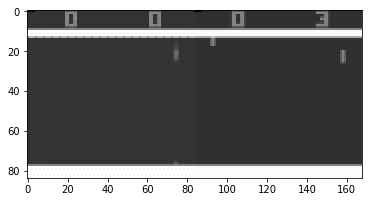

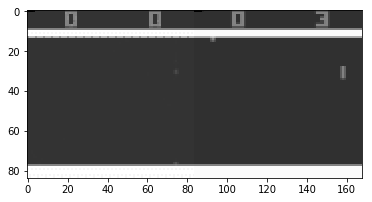

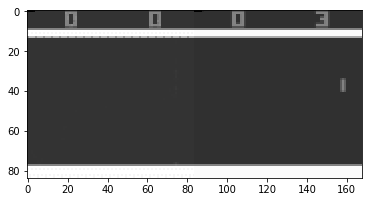

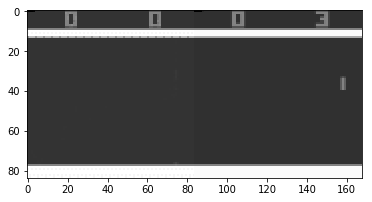

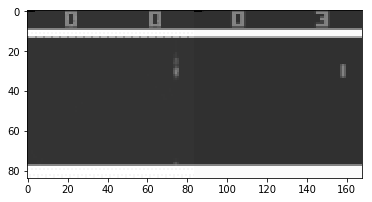

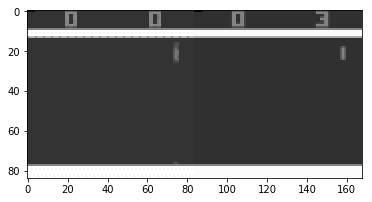

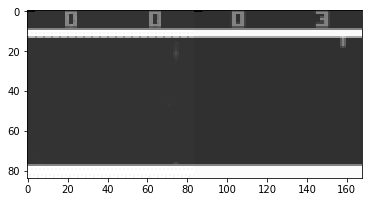

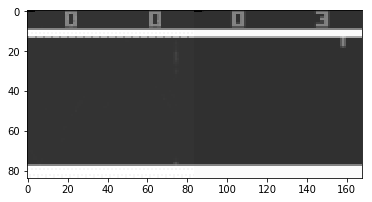

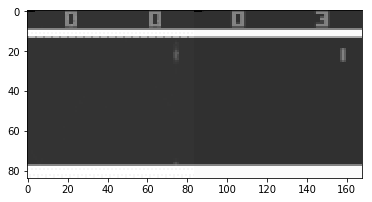

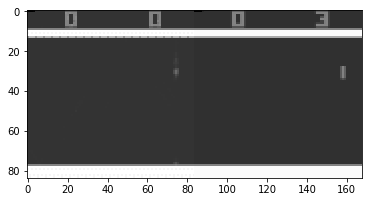

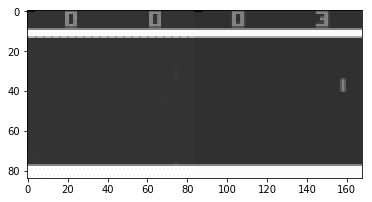

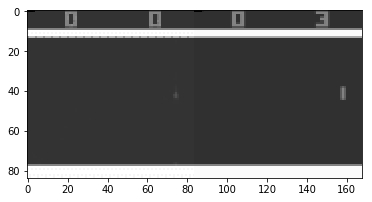

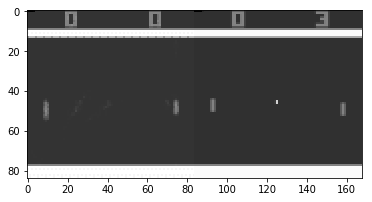

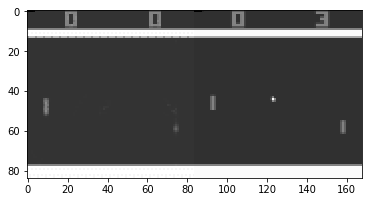

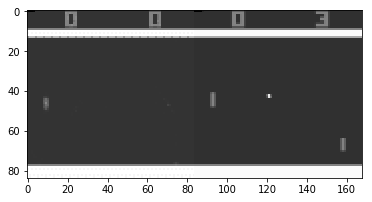

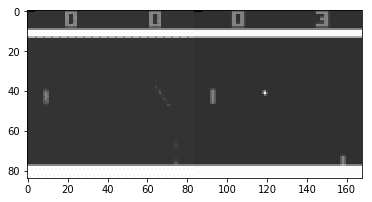

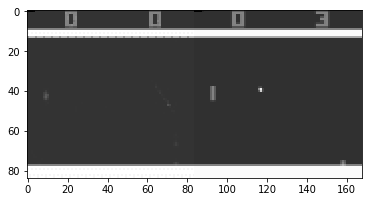

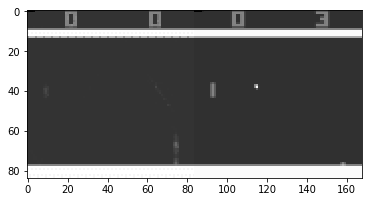

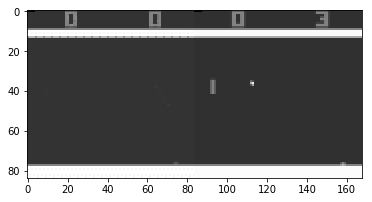

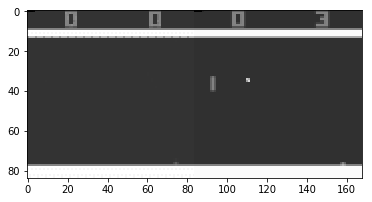

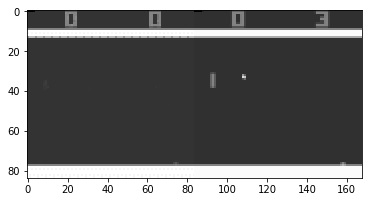

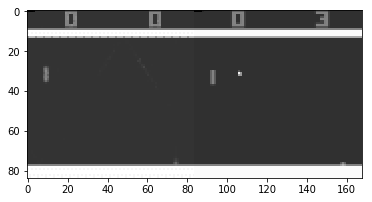

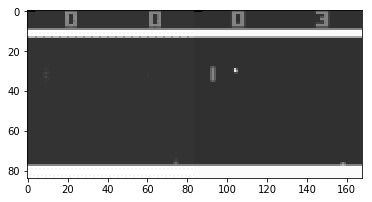

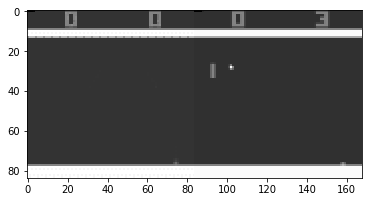

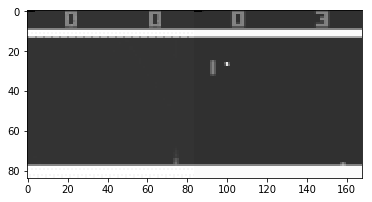

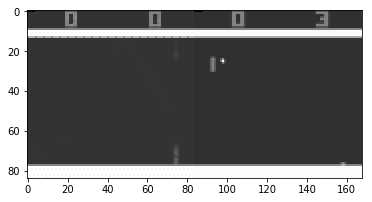

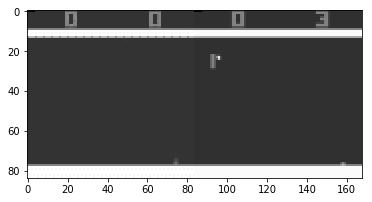

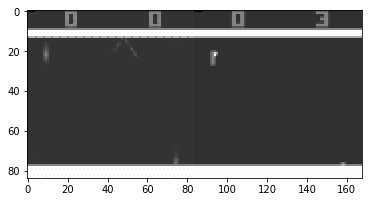

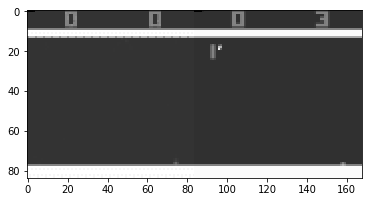

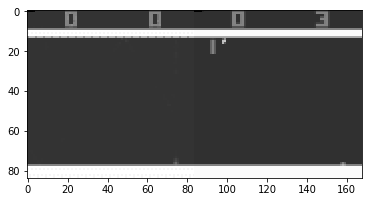

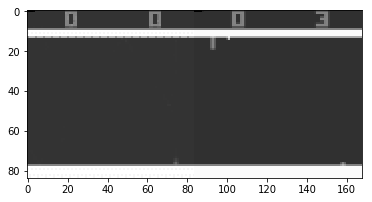

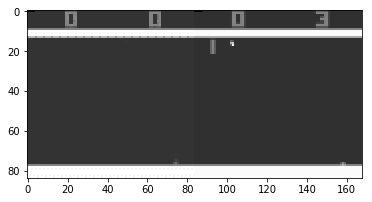

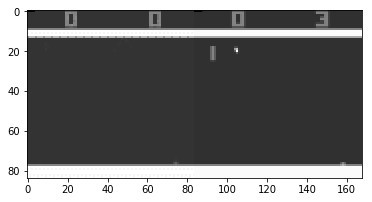

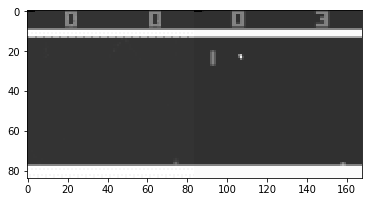

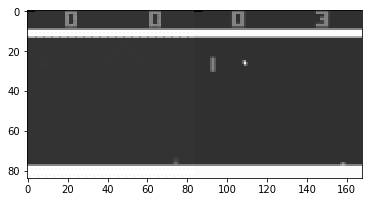

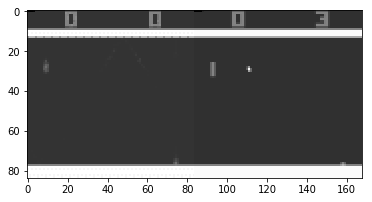

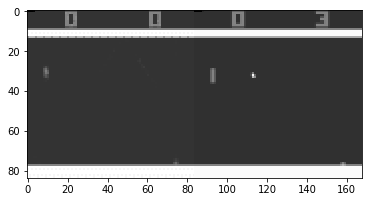

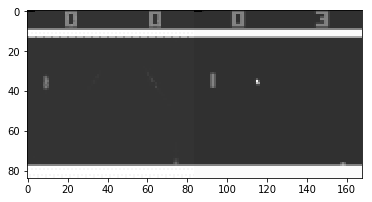

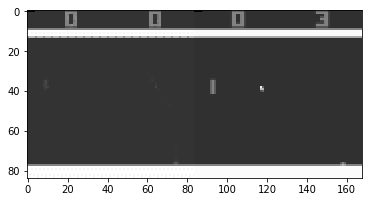

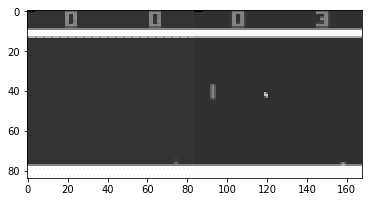

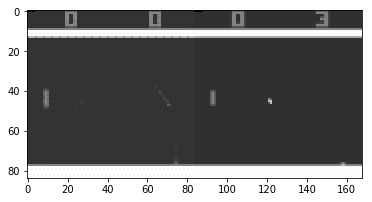

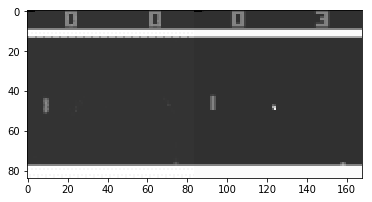

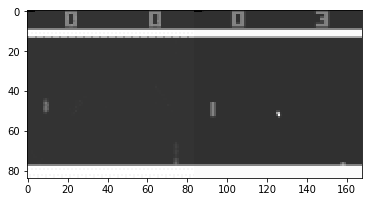

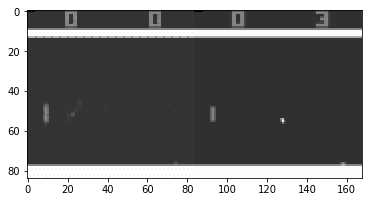

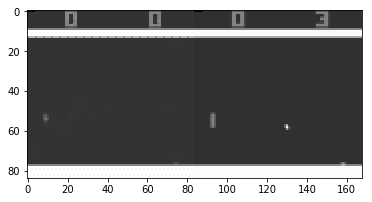

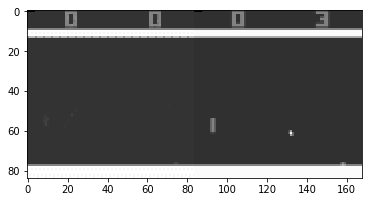

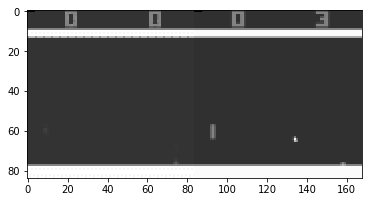

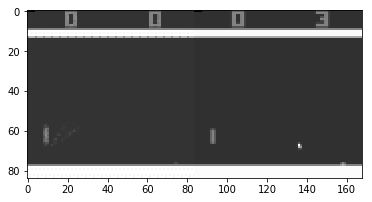

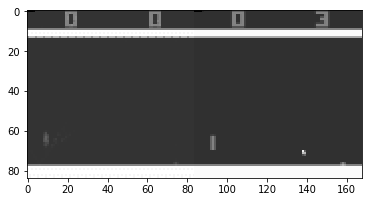

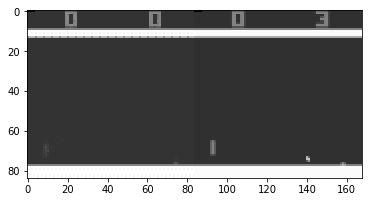

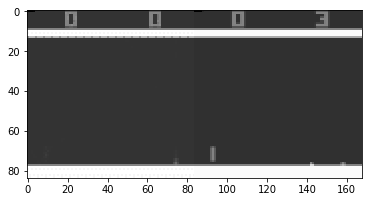

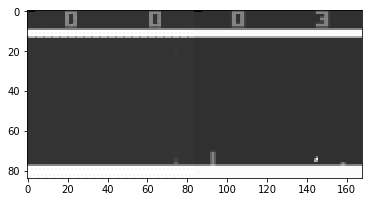

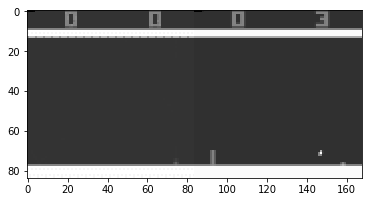

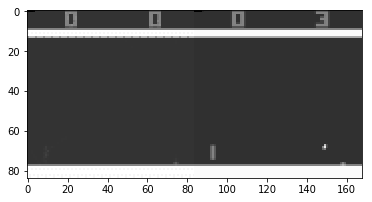

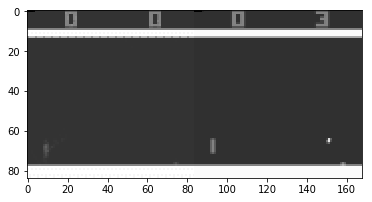

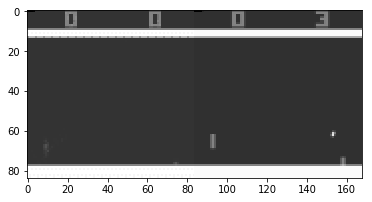

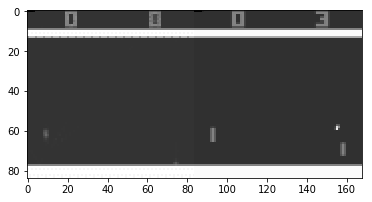

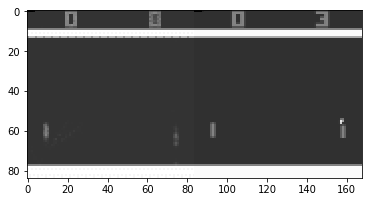

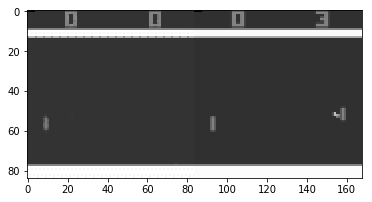

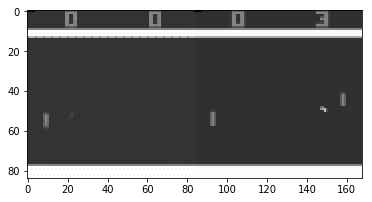

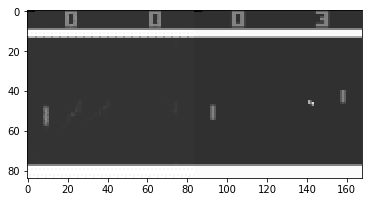

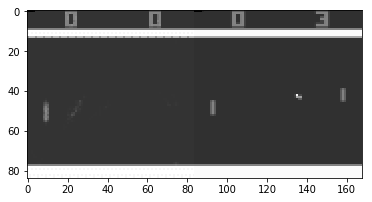

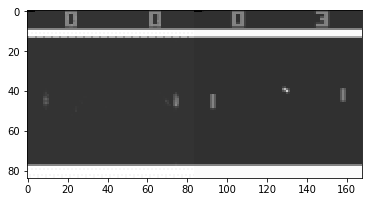

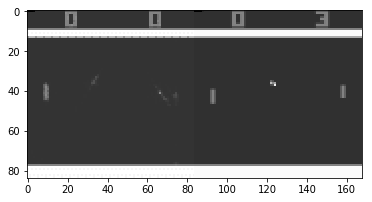

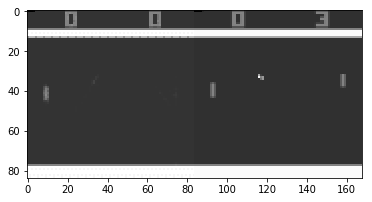

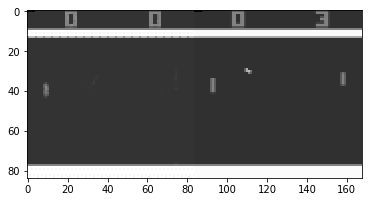

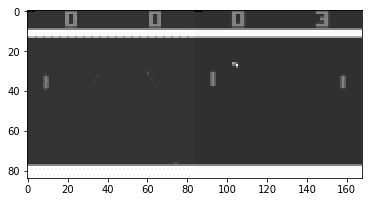

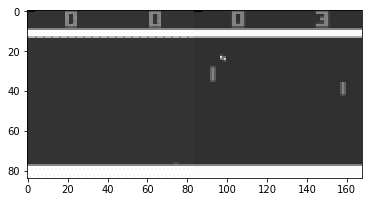

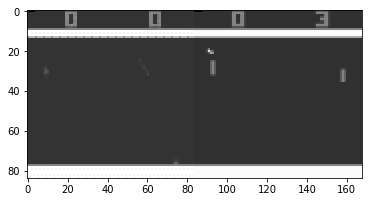

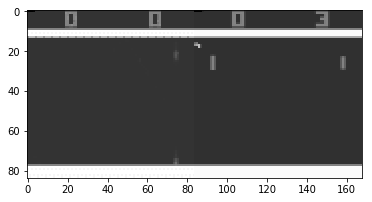

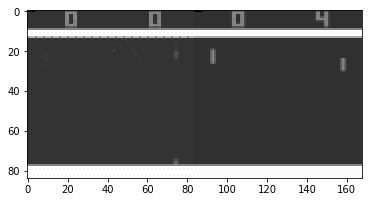

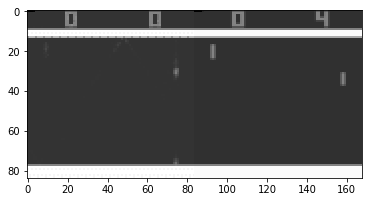

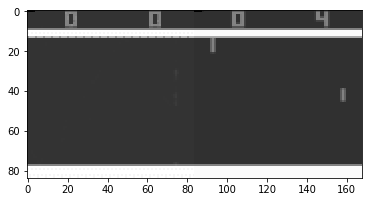

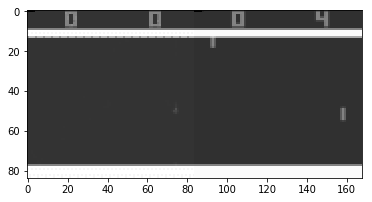

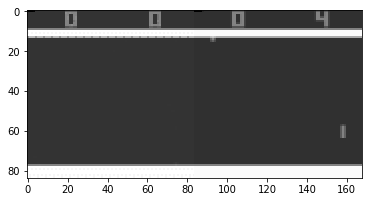

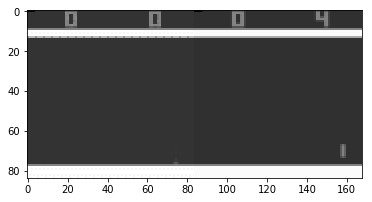

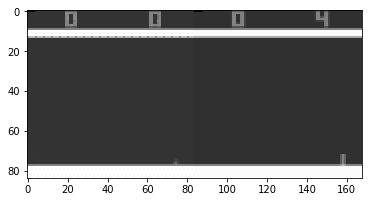

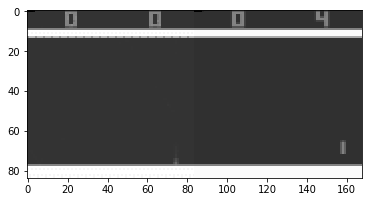

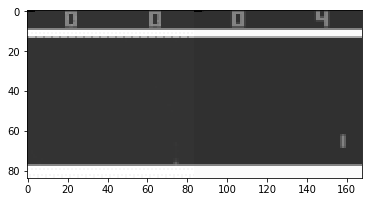

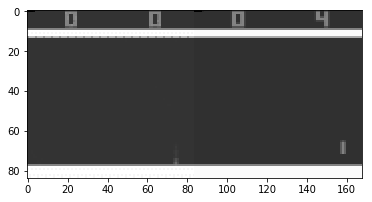

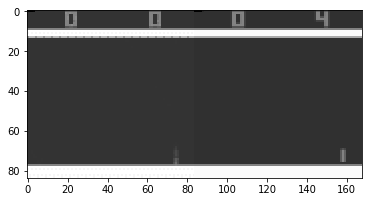

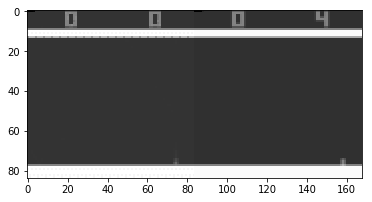

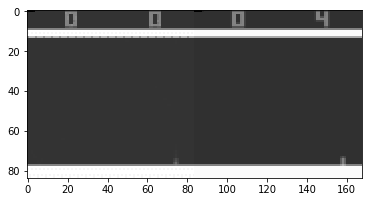

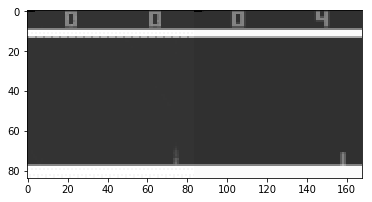

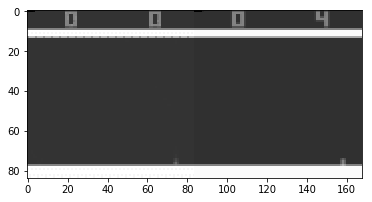

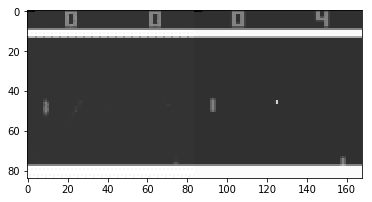

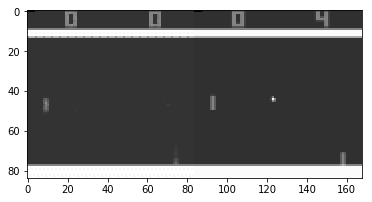

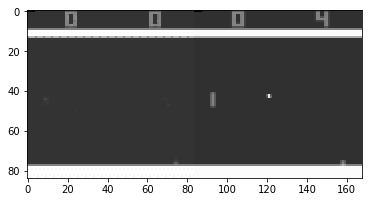

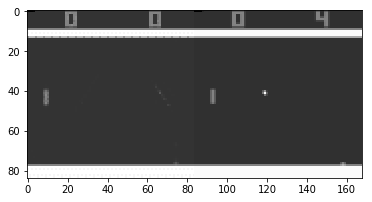

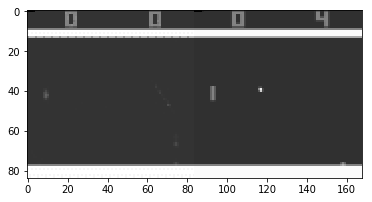

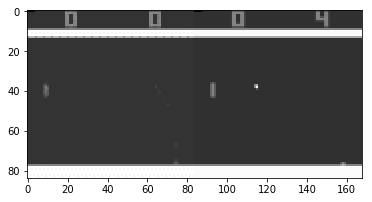

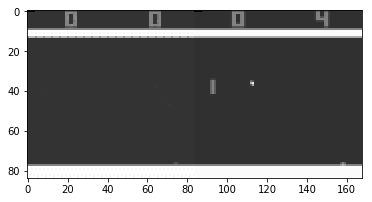

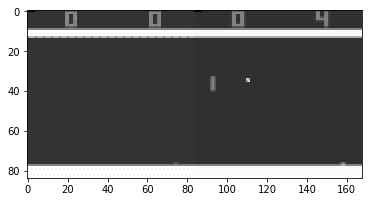

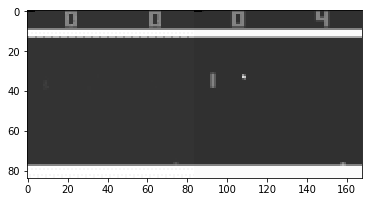

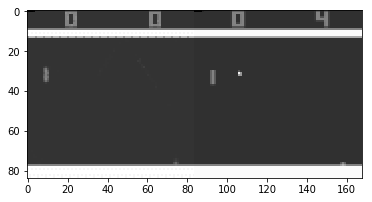

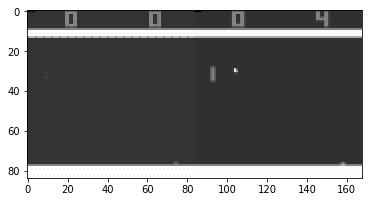

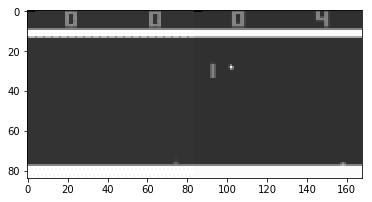

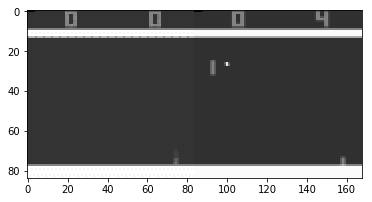

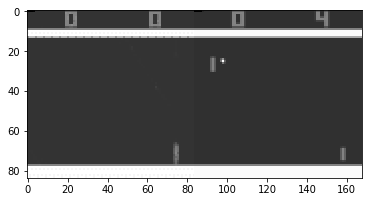

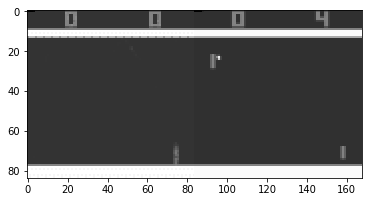

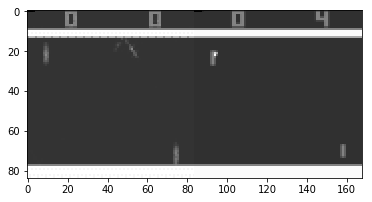

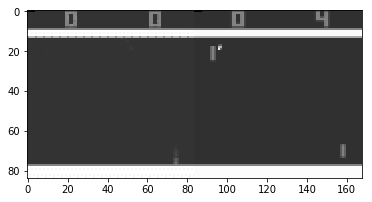

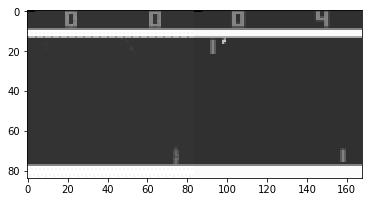

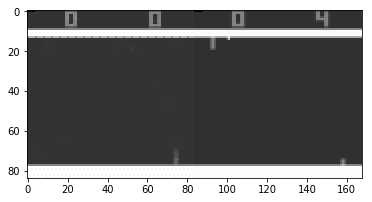

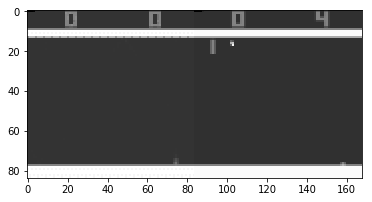

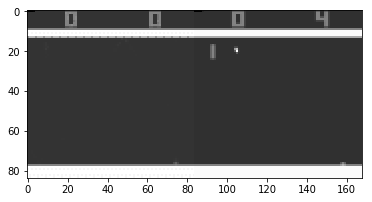

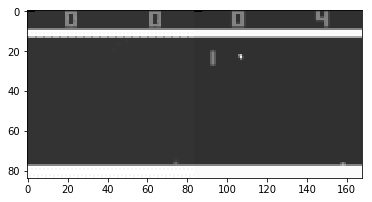

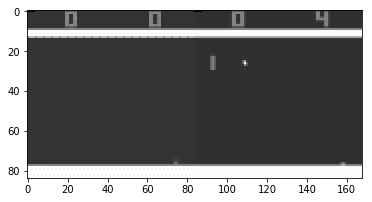

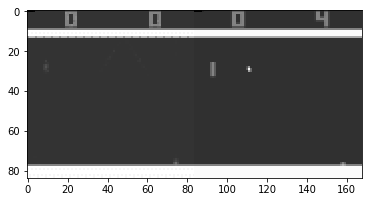

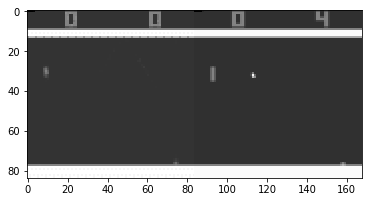

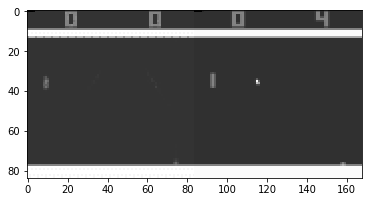

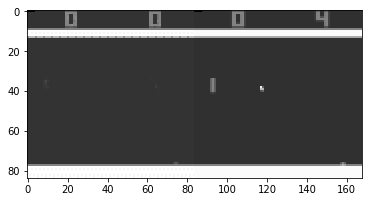

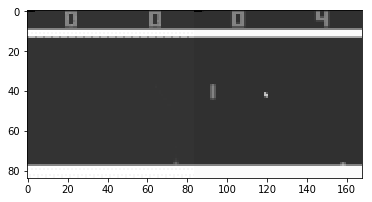

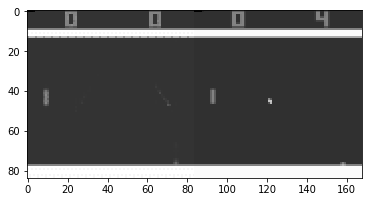

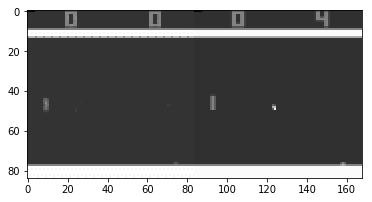

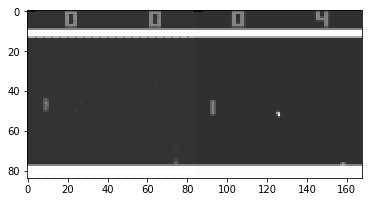

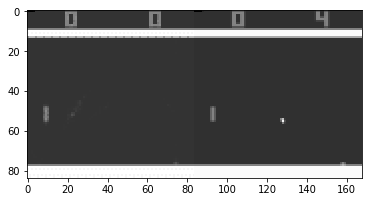

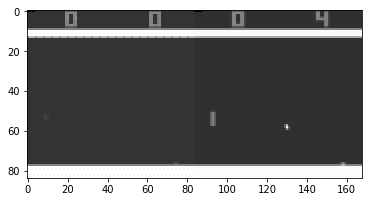

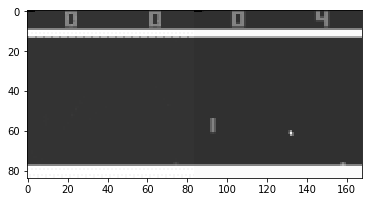

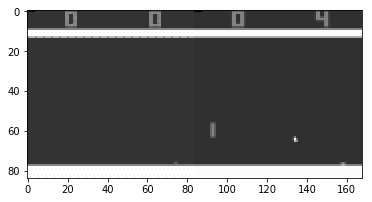

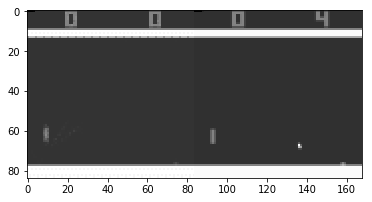

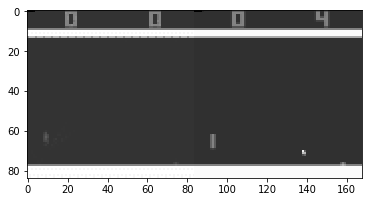

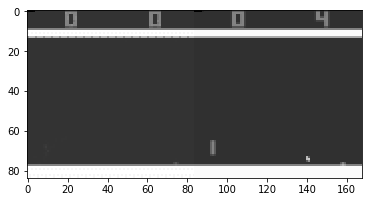

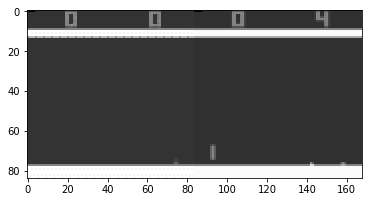

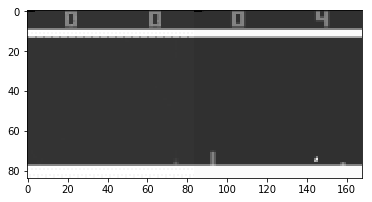

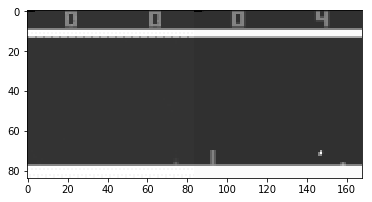

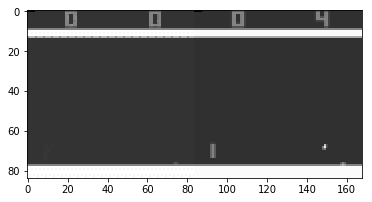

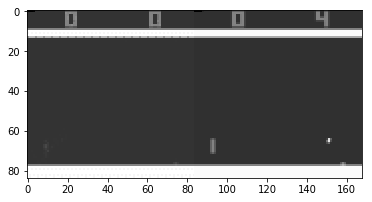

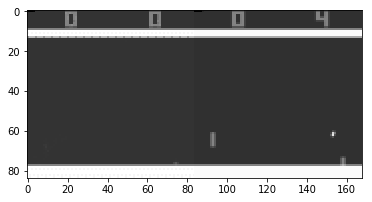

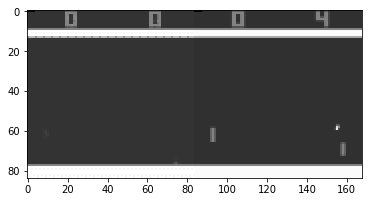

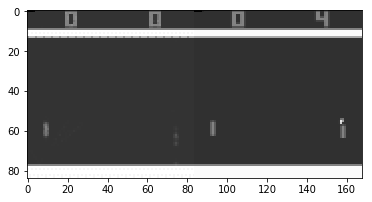

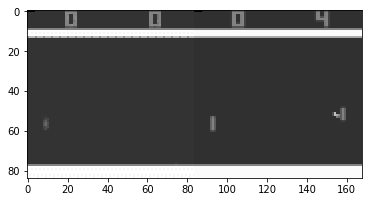

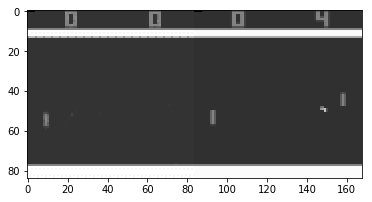

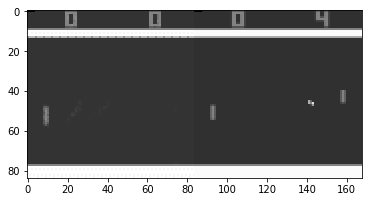

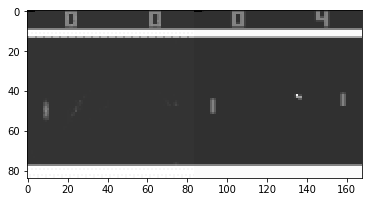

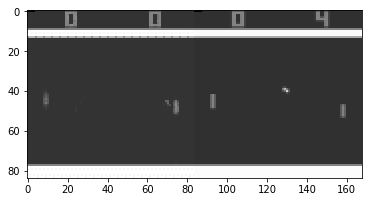

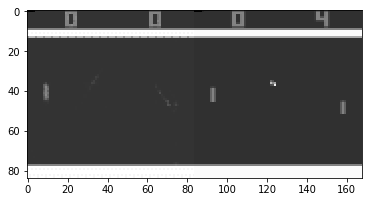

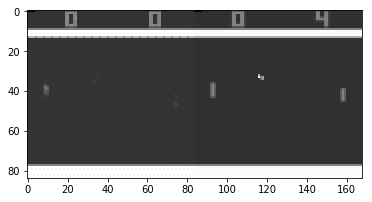

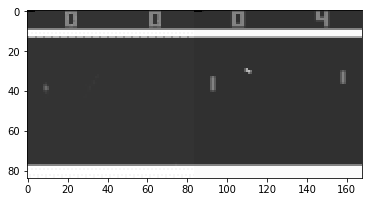

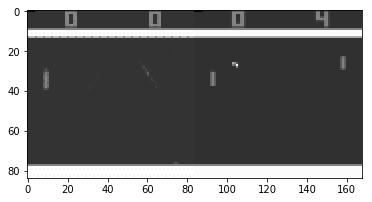

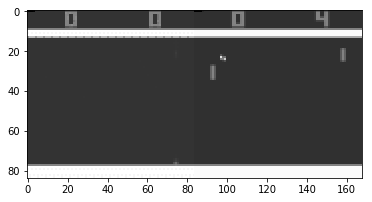

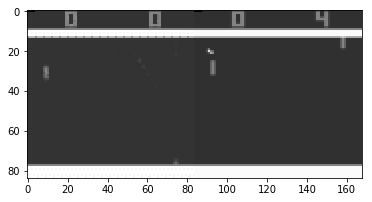

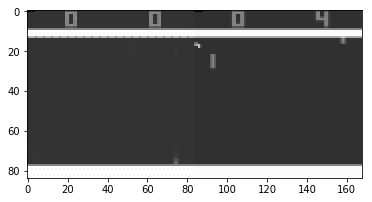

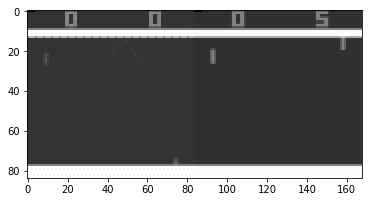

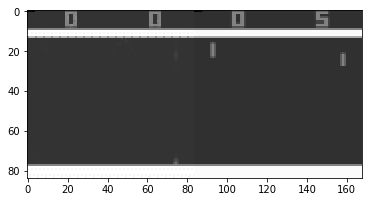

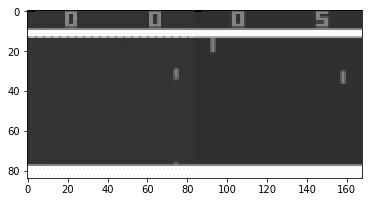

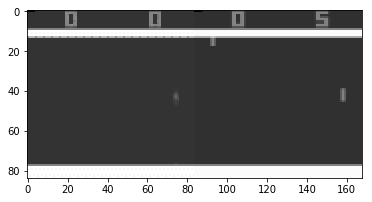

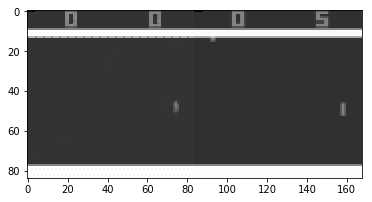

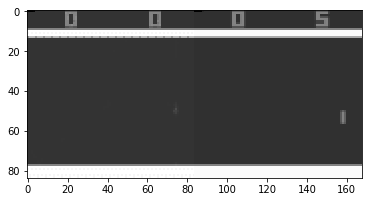

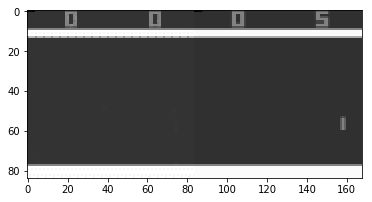

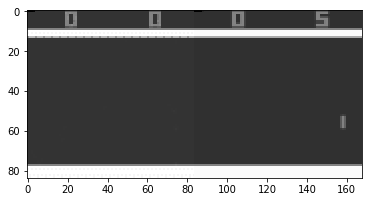

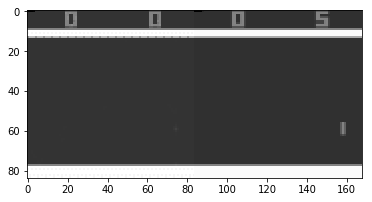

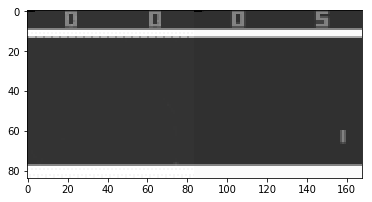

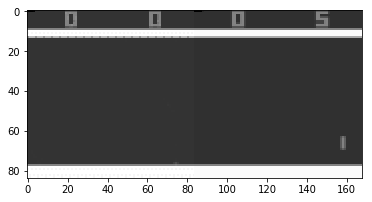

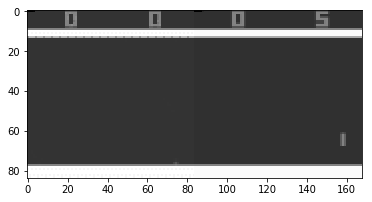

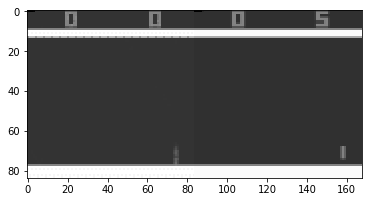

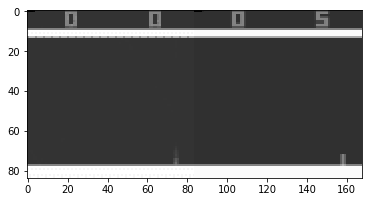

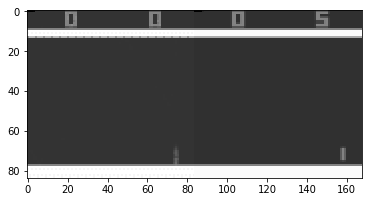

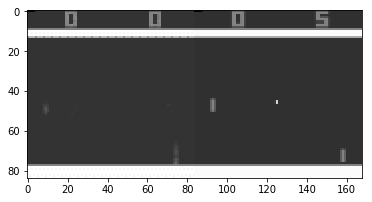

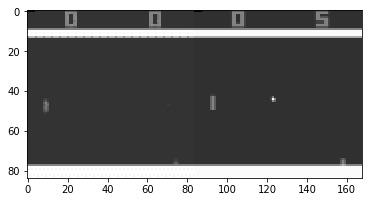

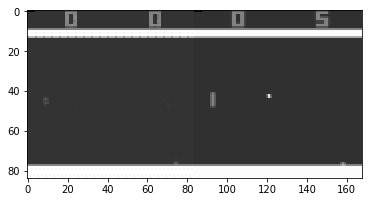

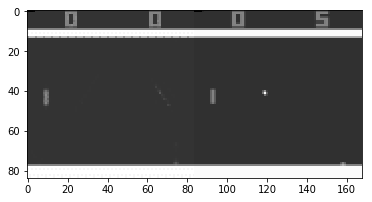

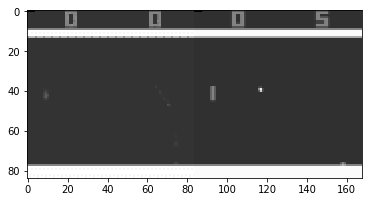

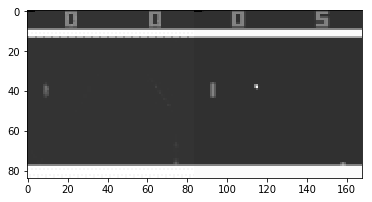

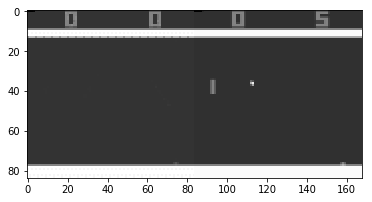

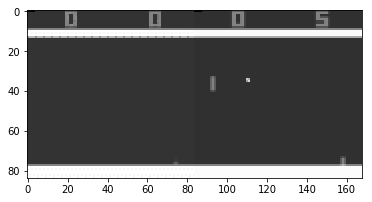

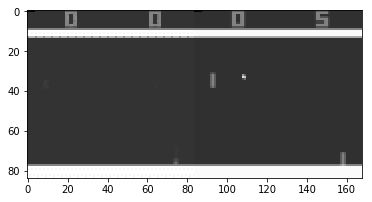

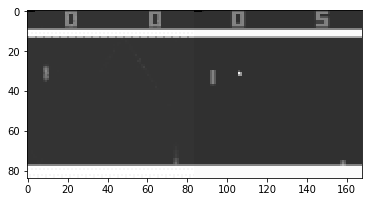

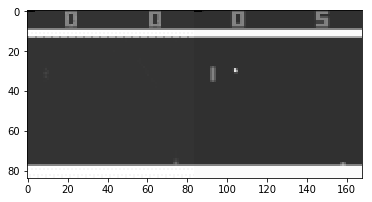

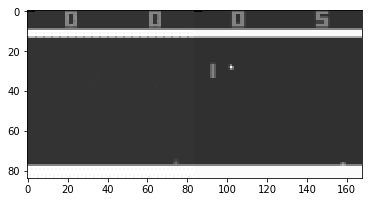

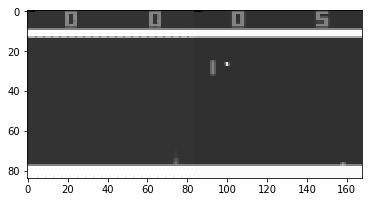

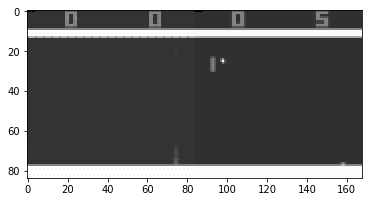

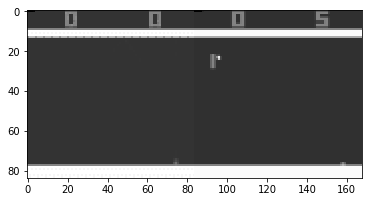

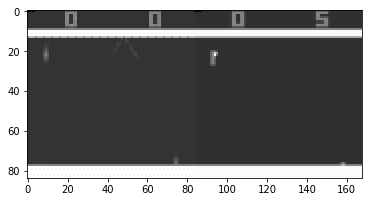

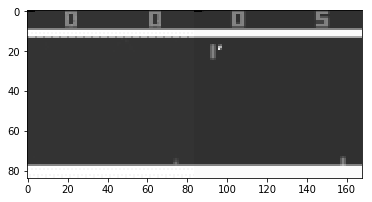

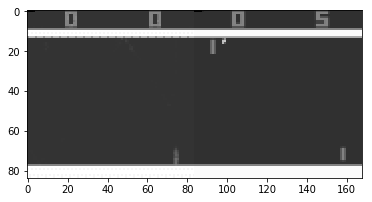

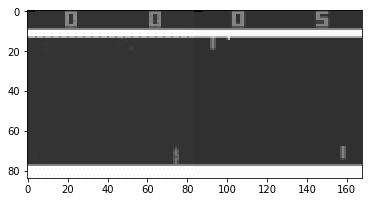

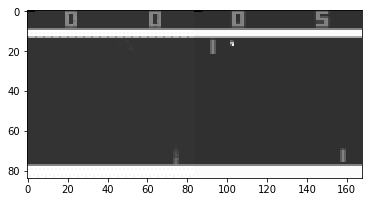

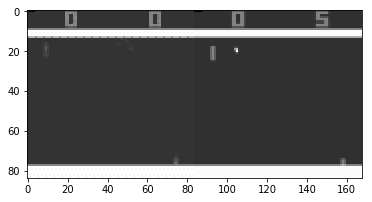

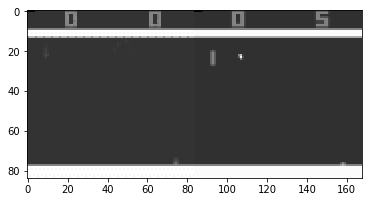

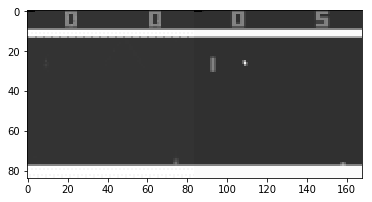

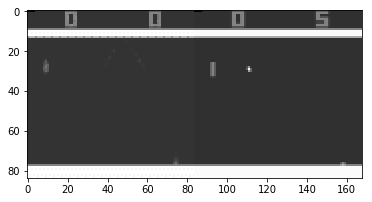

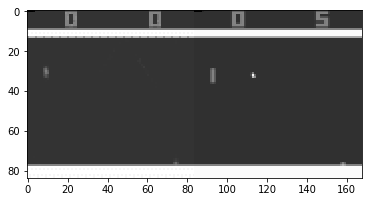

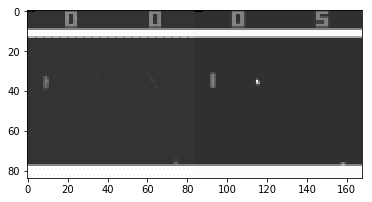

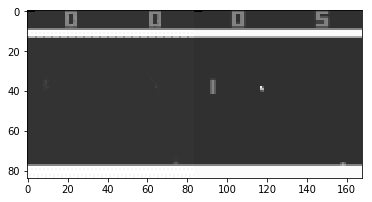

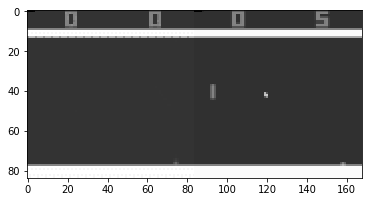

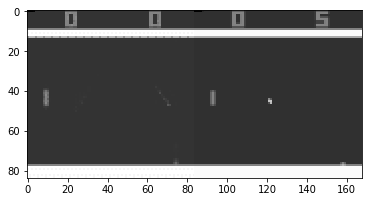

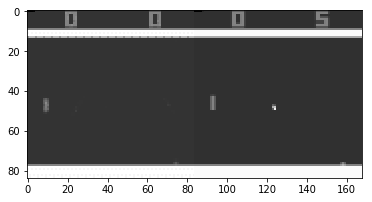

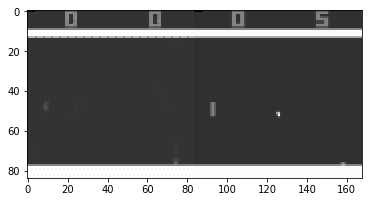

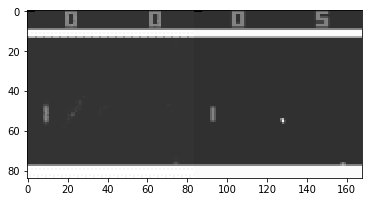

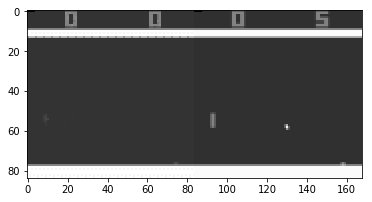

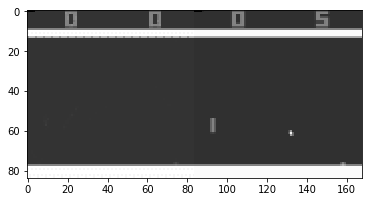

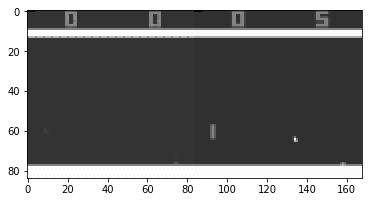

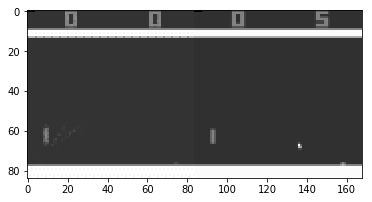

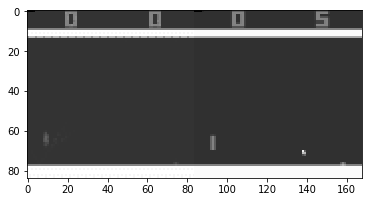

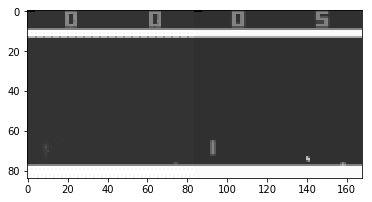

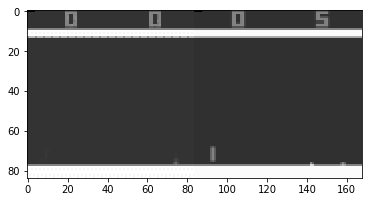

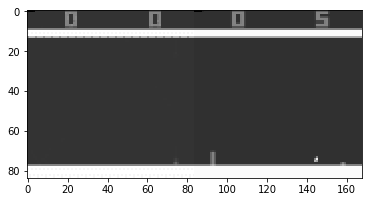

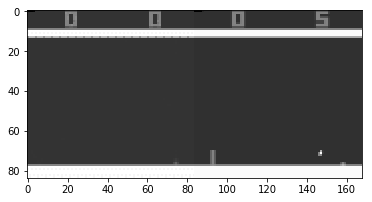

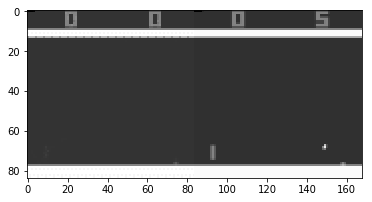

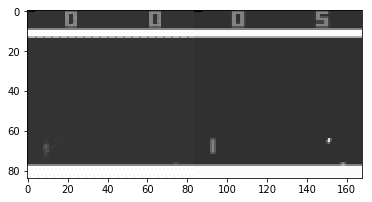

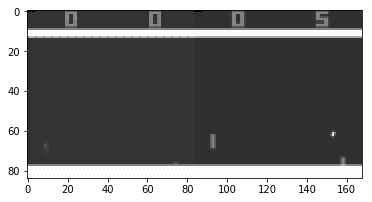

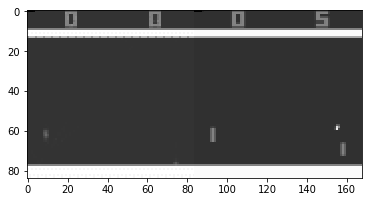

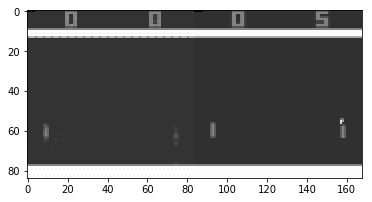

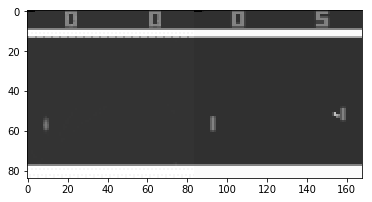

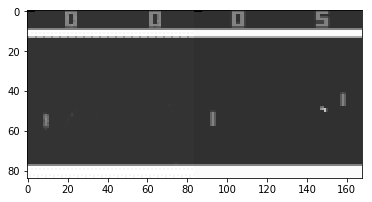

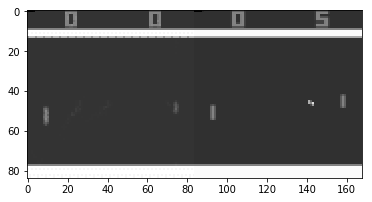

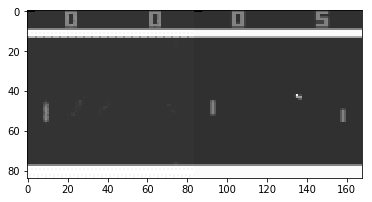

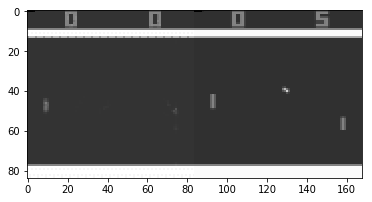

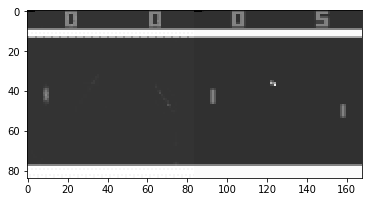

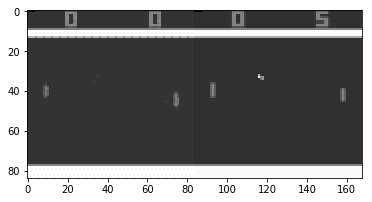

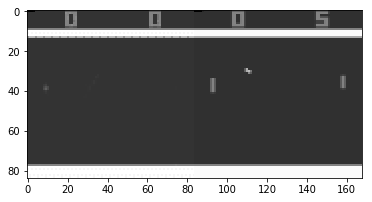

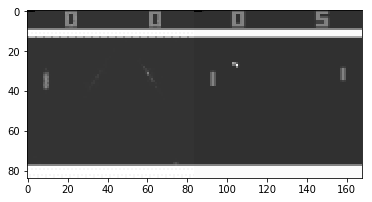

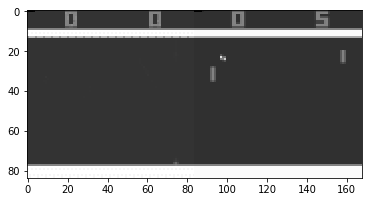

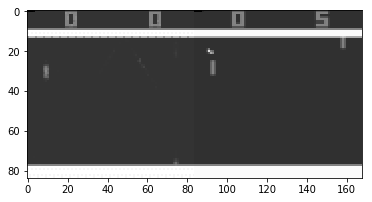

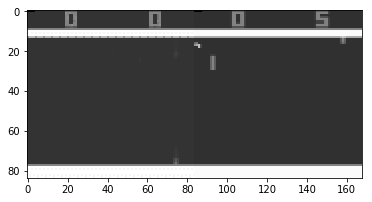

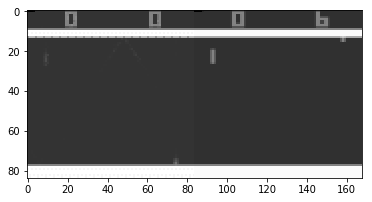

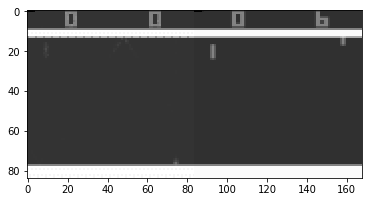

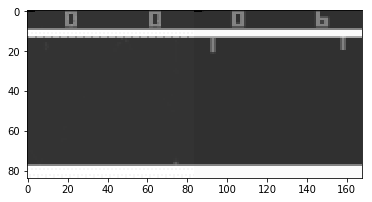

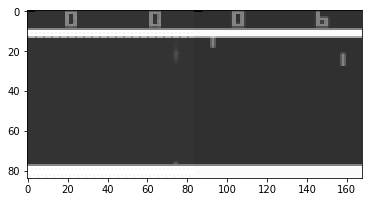

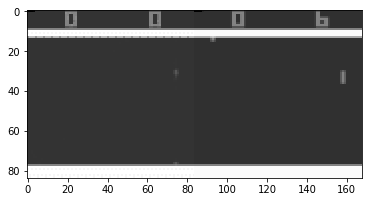

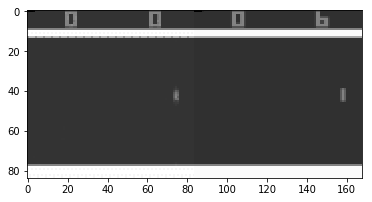

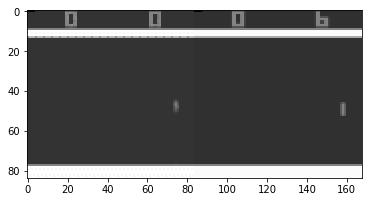

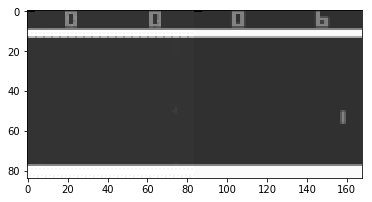

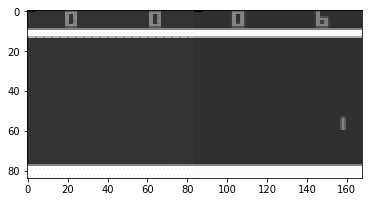

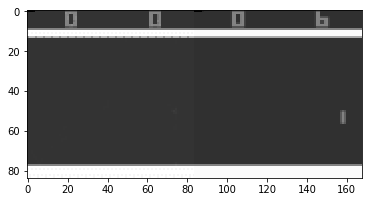

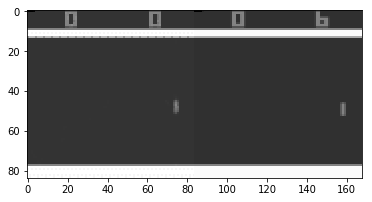

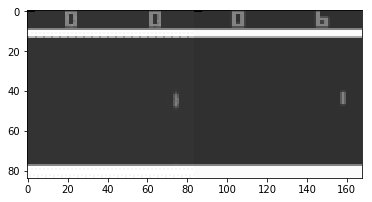

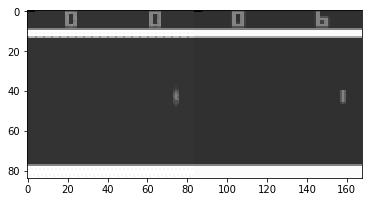

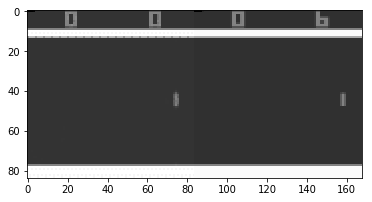

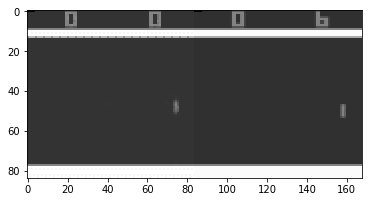

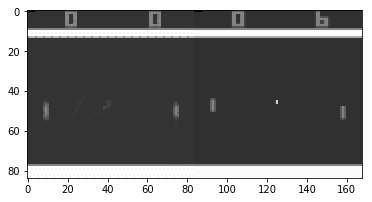

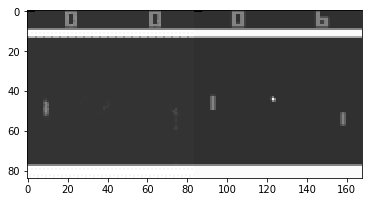

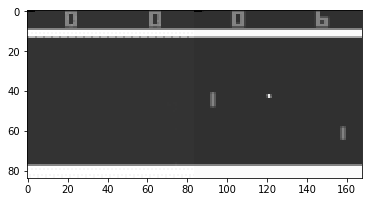

In [173]:

def show_idx(idx):
    plt.imshow(np.hstack([img[idx], tup[0][idx, :, :, -1]]), cmap='gray')
    plt.show()

for i in range(len(img)):
    show_idx(i)

In [136]:
tup[0][:5, :, :, -1:].shape

(5, 84, 84, 1)

In [20]:
%debug

> <ipython-input-16-52257723326b>(3)<module>()
      1 mean_img = img.mean(axis=0)
      2 np.mean((img - mean_img) ** 2)
----> 3 plt.hist((img - mean_img).reshape(100 * 84 * 84), bins=100)

ipdb> exit()


In [21]:
with tf.Graph().as_default() as graph:
    with tf.Session().as_default() as sess:
        encoder = Encoder((84, 84, 4), 6)

        
        #a = deconv(start_conv, 'deconv', nf=64, rf=3, stride=1)
        start_shape = tuple(s.value for s in encoder.final_cnn_shape[1:])
        print(start_shape)
        enhance = fc(encoder.output, 'out_shape', nh=np.prod(start_shape))
        start_conv = tf.reshape(enhance, [-1, *start_shape])

        l1 = tf.layers.conv2d_transpose(start_conv, 64, 3, strides=1)
        l2 = tf.layers.conv2d_transpose(l1, 32, 4, strides=2)
        l3 = tf.layers.conv2d_transpose(l2, 4, 8, strides=4)
        y = tf.nn.sigmoid(l3) * 255
        
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())
        #y - tf.to_float(encoder.obs_t)
        print(sess.run(
            -tf.reduce_mean((y - tf.to_float(encoder.obs_t)) ** 2),
            #start_conv,
            feed_dict={
                encoder.obs_t: tup[0][:100]
            }
        ))
                     
        #fc_to_conv(encoder.output, (7, 7, 64), init_scale=1.0/np.sqrt(2)),
        #        'output', dout)
        #a = deconv(encoder.output, 'deconv', nf=64, rf=4, stride=2)
        
        #print(encoder.encode(tup[0][:100], tup[2][:100]).shape)

TypeError: dcgan_cnn() missing 1 required positional argument: 'dout'

In [ ]:
class VariationalAutoencoder:
    def __init__(reward_arch, dOshape, dU):
        self.dOshape = dOshape
        self.dU = dU
        
        with tf.variable_scope(name) as _vs:
            # Should be batch_size x T x dO/dU
            obs_dtype = tf.int32 if reward_arch == cnn_net else tf.float32
            self.obs_t = tf.placeholder(obs_dtype, list((None,) + self.dOshape), name='obs')
            self.nobs_t = tf.placeholder(obs_dtype, list((None,) + self.dOshape), name='nobs')
            self.act_t = tf.placeholder(tf.float32, [None, self.dU], name='act')
            self.nact_t = tf.placeholder(tf.float32, [None, self.dU], name='nact')
            self.labels = tf.placeholder(tf.float32, [None, 1], name='labels')
            self.lprobs = tf.placeholder(tf.float32, [None, 1], name='log_probs')
            self.lr = tf.placeholder(tf.float32, (), name='lr')

            with tf.variable_scope('discrim') as dvs:
                h_obs = dcgan_cnn(x, **conv_kwargs)
                h = tf.concat([h_obs, self.act_t], axis=1)
            
            log_pq = tf.reduce_logsumexp([log_p_tau, log_q_tau], axis=0)
            self.discrim_output = tf.exp(log_p_tau-log_pq)
            self.accuracy, self.update_accuracy = tf.metrics.accuracy(
                labels=self.labels,
                predictions=self.discrim_output > 0.5
            )
            self.loss = -tf.reduce_mean(self.labels*(log_p_tau-log_pq) + (1-self.labels)*(log_q_tau-log_pq))
            self.step = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
            self._make_param_ops(_vs)

            self.grad_reward = tf.gradients(self.reward, [self.obs_t, self.act_t])

            self.modify_obs = self.get_ablation_modifiers()
            self.mean_score = 0

In [ ]:
     @overrides
    def fit(self, paths, policy=None, batch_size=256, logger=None, lr=1e-3, itr=0, **kwargs):
        if isinstance(self.expert_trajs[0], dict):
            self._insert_next_state(self.expert_trajs)
            expert_obs_base, expert_obs_next_base, expert_acts, expert_acts_next = \
                self.extract_paths(self.expert_trajs, keys=(
                    'observations', 'observations_next',
                    'actions', 'actions_next'
                ))
        else:
            expert_obs_base, expert_obs_next_base, expert_acts, expert_acts_next, _ = \
                self.expert_trajs

        #expert_probs = paths.sampler.get_a_logprobs(
        obs, obs_next, acts, acts_next, path_probs = paths.extract_paths((
            'observations', 'observations_next', 'actions', 'actions_next', 'a_logprobs'
        ), obs_modifier=self.modify_obs)

        expert_obs = expert_obs_base
        expert_obs_next = expert_obs_next_base

        # Train discriminator
        for it in TrainingIterator(self.max_itrs, heartbeat=5):
            nobs_batch, obs_batch, nact_batch, act_batch, lprobs_batch = \
                self.sample_batch(obs_next, obs, acts_next, acts, path_probs, batch_size=batch_size)

            nexpert_obs_batch, expert_obs_batch, nexpert_act_batch, expert_act_batch = \
                self.sample_batch(
                    expert_obs_next,
                    expert_obs,
                    expert_acts_next,
                    expert_acts,
                    # expert_probs,
                    batch_size=batch_size
                )
            expert_lprobs_batch = paths.sampler.get_a_logprobs(
                expert_obs_batch,
                expert_act_batch
            )
            expert_obs_batch = self.modify_obs(expert_obs_batch)
            nexpert_obs_batch = self.modify_obs(nexpert_obs_batch)

            # Build feed dict
            labels = np.zeros((batch_size*2, 1))
            labels[batch_size:] = 1.0
            obs_batch = np.concatenate([obs_batch, expert_obs_batch], axis=0)
            nobs_batch = np.concatenate([nobs_batch, nexpert_obs_batch], axis=0)
            act_batch = np.concatenate([act_batch, expert_act_batch], axis=0)
            nact_batch = np.concatenate([nact_batch, nexpert_act_batch], axis=0)
            lprobs_batch = np.expand_dims(np.concatenate([lprobs_batch, expert_lprobs_batch], axis=0), axis=1).astype(np.float32)

            feed_dict = {
                self.act_t: act_batch,
                self.obs_t: obs_batch,
                self.nobs_t: nobs_batch,
                self.nact_t: nact_batch,
                self.labels: labels,
                self.lprobs: lprobs_batch,
                self.lr: lr
            }

            loss, _, acc, scores = tf.get_default_session().run(
                [self.loss, self.step, self.update_accuracy, self.discrim_output],
                feed_dict=feed_dict
            )
            scores = np.log(scores) - np.log(1-scores)
            it.record('loss', loss)
            it.record('accuracy', acc)
            # we only want the average score for the non-expert demos
            it.record('avg_score', np.mean(scores[:batch_size]))
            if it.heartbeat:
                print(it.itr_message())
                mean_loss = it.pop_mean('loss')
                print('\tLoss:%f' % mean_loss)
                mean_acc = it.pop_mean('accuracy')
                print('\tAccuracy:%f' % mean_acc)
                mean_score = it.pop_mean('avg_score')

        if logger:
            logger.record_tabular('GCLDiscrimLoss', mean_loss)
            logger.record_tabular('GCLDiscrimAccuracy', mean_acc)
            logger.record_tabular('GCLMeanScore', mean_score)
        self.mean_score = mean_score
        return mean_loss

In [ ]:
def log_likelihood(mean, sigsq, X):
    return -0.5 * ((X - mean) ** 2 / sigsq) - 0.5 * tf.log(2 * np.pi * sigsq)

with tf.Graph().as_default() as graph:
    with tf.Session().as_default() as sess:
        obs_t = tf.placeholder(tf.float32, [None, 84, 84, 1], name='obs')
        #means = tf.get_variable('mean', [5], dtype=tf.float32)
        #sigsqs = tf.get_variable('sigsq', [5], dtype=tf.float32)
        #unk_value = tf.constant(1.0/255)

        #weird = -1 * log_likelihood(means, sigsqs, obs_t)
        dist = tf.distributions.Normal(loc=means, scale=sigsqs)
        print(dist.prob(obs_t).shape)
        
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())